## Research Question

This notebook addresses **Research Question 1** from our project proposal:

> *"Can we detect mispriced listings by comparing them against a predicted market rate?"*

**Approach:**
- Train ML models to predict fair market price based on property attributes, location features, and competitive signals
- Compare predicted prices against actual listing prices to identify mispricing
- Provide contextualized recommendations for hosts

**Data Sources Used:**
1. **Airbnb Dataset** - Property attributes, amenities, pricing, reviews
2. **Booking.com Dataset** - Hotel competition metrics (count, ratings, reviews)
3. **OpenStreetMap** - POI density (restaurants, cafes, transit, etc.)

## Load Data

In [0]:
# config
storage_account = "lab94290"  
container = "airbnb"
sas_token="sp=rle&st=2025-12-24T17:37:04Z&se=2026-02-28T01:52:04Z&spr=https&sv=2024-11-04&sr=c&sig=a0lx%2BS6PuS%2FvJ9Tbt4NKdCJHLE9d1Y1D6vpE1WKFQtk%3D"
sas_token = sas_token.lstrip('?')
spark.conf.set(f"fs.azure.account.auth.type.{storage_account}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{storage_account}.dfs.core.windows.net", sas_token)

In [0]:
path = f"abfss://{container}@{storage_account}.dfs.core.windows.net/airbnb_1_12_parquet"
airbnb_df = spark.read.parquet(path)

In [0]:
%pip install reverse_geocoder pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.2 MB ? eta -:--:--
     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/2.2 MB 14.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.2/2.2 MB 36.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for pycountry from https://files.pythonhosted.org/packages/b1/ec/1fb891d8a2660716aadb2143235481d15ed1cbfe3ad669194690b0604492/pycountry-24.6.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.3 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 3.8/6.3 MB 116.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 6.3/6.3 MB 131.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.3 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.w

In [0]:
# Standard Python libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PySpark SQL functions
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, when, round, abs, concat, lit, avg, count, sum as spark_sum
)

from pyspark.sql.types import *
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.window import Window

# PySpark ML - Feature Engineering
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    Imputer
)
from pyspark.ml import Pipeline

# PySpark ML - Models
from pyspark.ml.regression import (
    RandomForestRegressor,
    GBTRegressor  # Gradient Boosted Trees
)

# PySpark ML - Evaluation
from pyspark.ml.evaluation import RegressionEvaluator

# PySpark ML - Tuning (for hyperparameter tuning)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# PySpark ML - Statistics (for correlation analysis)
from pyspark.ml.stat import Correlation

# MLflow for model tracking (already in your notebook)
import mlflow
import mlflow.spark

## EDA

In [0]:
# display(airbnb_df.limit(5))

name price image description category availability discount reviews ratings seller_info breadcrumbs location lat long guests pets_allowed description_items category_rating house_rules details highlights arrangement_details amenities images available_dates url final_url listing_title property_id listing_name location_details description_by_sections description_html location_details_html is_supperhost host_number_of_reviews host_rating hosts_year host_response_rate is_guest_favorite travel_details pricing_details total_price currency cancellation_policy property_number_of_reviews country postcode_map_url host_image host_details Rental unit in Broadbeach · ★4.96 · 2 bedrooms · 2 beds · 1 bath 238 https://a0.muscache.com/pictures/50ddeaed-5302-4d0c-8200-163b2cddd071.jpg Our exceptionally stylish two bedroom, one bathroom LUXURY holiday apartment is located in the ORACLE T2, right in the heart of beautiful Broadbeach! Every corner of this gorgeous apartment overflows with style, luxury and thoughtful touches. Relax on the ocean facing balcony located directly above the manicured garden terrace and take in the relaxing views and sea breezes. This property is all class and guaranteed to satisfy even the fussiest Airbnb guest!The spaceThe photos speak for themselves. They are a true, accurate and up to date representation of our immaculately presented, squeaky clean, apartment. The furnishings are practical and comfortable and the linen and bedding are soft and luxurious. The master king bedroom opens out onto the large balcony. The second bedroom is a small internal room with a comfortable high quality queen sized bed. The second bedroom does not have a window. Each bedroom has an internal sliding door which provides access to the two way bathroom. Our apartment has been styled with a relaxing holiday in mind.Guest accessPoolSpaGymSauna and steam roomBBQ and entertaining areasGardensSecure off street parking for ONE vehicleAccess to facilities is not guaranteed and may be interrupted by routine and unexpected maintenance schedules.Other things to noteThis property accommodates up to FOUR people only. Children aged two and older are included in the four people rule. No exceptions. Infants UNDER the age of two are very welcome at our place and may stay at no additional charge however we do not provide linen or bedding. Let us know if you would like the link to a local business who hires out baby equipment (travel cots, strollers, high chairs).CHECK IN Available between 3pm and 9pm.Self check in is NOT available at this property. After hours check ins are NOT available. A 3pm check in is not guaranteed and depends on cleaning schedules. CHECK IN APPOINTMENTOur lovely host welcomes you in person on arrival. The booking guest is required to make contact with us via the booking message thread prior to their arrival day to arrange a check in time. A host will not be onsite to meet you unless you have scheduled a check in time. We always do our best to fit in with your travel schedule. IMPORTANTKeys and security fobs will only be issued to the person who made the booking. ID will be required. This is not negotiable. Please read the HOUSE RULES and CANCELLATION POLICY prior to booking our place. We recommend taking out travel insurance to cover any losses which may occur if you need to cancel your booking for an unforeseen reason. NO SMOKING - smoking is NOT permitted anywhere at this complex.CHECK IN / CHECK OUT - NOT AVAILABLE* Christmas Day* New Years Day * Easter SundayEARLY CHECK IN - We will always accommodate an early check in if our place is available. CHECK OUT by 11am - Late check outs are not available and hold up our cleaning team. WHAT WE INCLUDE IN OUR STARTER PACKOur starter pack is designed to help get you started on your holiday and may not last the entire trip. If you are with us for more than two nights, you may need to re stock items at the local supermarket. Woolworths supermarket is located right next door for any additi

In [0]:
# # Basic info
# print("="*60)
# print("DATASET OVERVIEW")
# print("="*60)
# print(f"Total Records: {airbnb_df.count():,}")
# print(f"Total Columns: {len(airbnb_df.columns)}")
# print("\nSchema:")
# airbnb_df.printSchema()

DATASET OVERVIEW
Total Records: 2,098,880
Total Columns: 50

Schema:
root
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- image: string (nullable = true)
 |-- description: string (nullable = true)
 |-- category: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- discount: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- seller_info: string (nullable = true)
 |-- breadcrumbs: string (nullable = true)
 |-- location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- guests: string (nullable = true)
 |-- pets_allowed: string (nullable = true)
 |-- description_items: string (nullable = true)
 |-- category_rating: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- details: string (nullable = true)
 |-- highlights: string (nullable = true)
 |-- arrangement_details: string (nullable = true)
 |-- amenities: strin

In [0]:
# display(airbnb_df.filter(F.col("postcode_map_url").isNotNull()).limit(5))

In [0]:
# display(airbnb_df.filter(F.col("breadcrumbs") != F.col("location")))

In [0]:
# # Check for null or empty values for seller_info coulmn
# null_or_empty_count = airbnb_df.filter(
#     (F.col("seller_info").isNull()) | (F.trim(F.col("seller_info")) == "")
# ).count()
# print(f"Rows where seller_info is null or empty: {null_or_empty_count}")

# # print rows where seller_info is null or empty
# print("Rows where seller_info is null or empty:")
# display(
#     airbnb_df.filter(
#         (F.col("seller_info").isNull()) | (F.trim(F.col("seller_info")) == "")
#     )
# )

In [0]:
# # 1. Check if ALL rows parse successfully with the expected schema
# parsed_test = airbnb_df.withColumn(
#     "cancel_parsed",
#     F.from_json(F.col("cancellation_policy"), "array<struct<cancellation_name:string,cancellation_value:string>>")
# )

# total = airbnb_df.count()
# parse_success = parsed_test.filter(F.col("cancel_parsed").isNotNull()).count()
# parse_fail = parsed_test.filter(F.col("cancel_parsed").isNull() & F.col("cancellation_policy").isNotNull()).count()

# print(f"Total: {total:,}")
# print(f"Parsed OK: {parse_success:,}")
# print(f"Parse failed (not null but didn't match schema): {parse_fail:,}")

In [0]:
# display(airbnb_df.groupBy("category").count().orderBy(F.desc("count")))

In [0]:
# exists_nonnull_host_details = airbnb_df.filter(F.col("host_details").isNotNull()).limit(1).count() > 0
# print(f"At least one row with non-null host_details: {exists_nonnull_host_details}")

In [0]:
# # Currency distribution - need to check if multi-currency issue
# airbnb_df.groupBy("currency").count().orderBy(F.desc("count")).show(20)

In [0]:
# display(airbnb_df.select("property_number_of_reviews", "reviews").where(F.col("property_number_of_reviews").isNull()).limit(5))

## Clean Data

In [0]:
# Columns to drop - no predictive value for price
drop_cols = [
    # URLs & Images (identifiers only)
    "image",
    "url",
    "final_url",
    "postcode_map_url",
    "host_image",
    
    # HTML duplicates (redundant with text versions)
    "description_html",
    "location_details_html",
    
    # Navigation/metadata
    "breadcrumbs",       # redundant with location

    # Same category, different languages
    "category",

    # All null
    "host_details",

    "travel_details", # search/booking query data, not property attributes
    
    # Temporal/dynamic (not property features)
    "available_dates",   # specific dates, not generalizable
    "availability",      # current state, not intrinsic
    "discount",          # temporary pricing distorts model

    # Redundant text fields - useful info extracted elsewhere
    "name",              # rating and details
    "listing_name",      # property type extracted from description_items
    "listing_title",     # host marketing text, too noisy for price prediction
    "arrangement_details",
    "house_rules",

    # rating categories - to prevent leakage
    "category_rating",
    "ratings",

    # text fields with no predictive value for price
    "location_details",
    "description_by_sections",
    "description",
    "highlights",

    "country",
]


clean_airbnb_df = airbnb_df.drop(*drop_cols)

In [0]:
clean_airbnb_df.cache()

DataFrame[price: double, lat: string, long: string, guests: string, pets_allowed: string, description_items: string, details: string, amenities: string, property_id: string, is_supperhost: string, host_number_of_reviews: string, host_rating: string, hosts_year: string, host_response_rate: string, is_guest_favorite: string, property_number_of_reviews: string, seller_id: string, city: string, state: string, country: string, num_images: int, cancellation_type: string, log_price: double]

In [0]:
# Extract seller_id and seller_url from seller_info
clean_airbnb_df = clean_airbnb_df.withColumn("seller_id", F.get_json_object("seller_info", "$.seller_id")) \
                     .drop("seller_info")

# Drop rows where seller_id is null or empty
clean_airbnb_df = clean_airbnb_df.filter(
    (F.col("seller_id").isNotNull()) & (F.trim(F.col("seller_id")) != "")
)

In [0]:
import reverse_geocoder as rg
import pycountry
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd
from pyspark.sql.functions import split, size, trim, element_at, when, col, pandas_udf

# Schema for all 4 columns
location_schema = StructType([
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("country", StringType()),
    StructField("country_code", StringType())
])

def get_country_name(cc):
    """Convert ISO country code to full name"""
    try:
        return pycountry.countries.get(alpha_2=cc).name
    except:
        return cc

@pandas_udf(location_schema)
def get_location_info(lat: pd.Series, lon: pd.Series) -> pd.DataFrame:
    n = len(lat)
    results = pd.DataFrame({
        'city': [None] * n,
        'state': [None] * n,
        'country': [None] * n,
        'country_code': [None] * n
    })
    
    valid_mask = lat.notna() & lon.notna()
    
    if valid_mask.any():
        valid_coords = [
            (lat.iloc[i], lon.iloc[i]) 
            for i in range(n) if valid_mask.iloc[i]
        ]
        geocoded = rg.search(valid_coords)
        
        idx = 0
        for i in range(n):
            if valid_mask.iloc[i]:
                results.loc[i, 'city'] = geocoded[idx]['name']
                results.loc[i, 'state'] = geocoded[idx]['admin1']
                results.loc[i, 'country_code'] = geocoded[idx]['cc']
                results.loc[i, 'country'] = get_country_name(geocoded[idx]['cc'])
                idx += 1
    
    return results


clean_airbnb_df = clean_airbnb_df.withColumn(
    "location_info",
    get_location_info(col("lat"), col("long"))
).select(
    "*",
    col("location_info.city").alias("city"),
    col("location_info.state").alias("state"),
    col("location_info.country").alias("country"),
    col("location_info.country_code").alias("country_code")
).drop("location_info")


clean_airbnb_df = clean_airbnb_df.withColumn("parts", split(col("location"), ",")) \
    .withColumn("num_parts", size(col("parts")))

clean_airbnb_df = clean_airbnb_df.withColumn(
    "country",
    when(col("lat").isNull() & col("long").isNull(), trim(element_at(col("parts"), -1)))
    .otherwise(col("country"))
).withColumn(
    "state",
    when(col("lat").isNull() & col("long").isNull() & (col("num_parts") >= 3), trim(element_at(col("parts"), -2)))
    .otherwise(col("state"))
).withColumn(
    "city",
    when(col("lat").isNull() & col("long").isNull() & (col("num_parts") >= 3), trim(element_at(col("parts"), -3)))
    .when(col("lat").isNull() & col("long").isNull() & (col("num_parts") == 2), trim(element_at(col("parts"), 1)))
    .otherwise(col("city"))
).drop("parts", "num_parts")

# manual cleanup
country_cleanup = {
    "XK": "Kosovo",
    "Korea, Republic of": "South Korea",
    "Viet Nam": "Vietnam",
    "Türkiye": "Turkey",
    "Taiwan, Province of China": "Taiwan",
    "Holy See (Vatican City State)": "Vatican City",
    "Bolivia, Plurinational State of": "Bolivia",
    "Tanzania, United Republic of": "Tanzania",
    "Venezuela, Bolivarian Republic of": "Venezuela",
    "Virgin Islands, U.S.": "US Virgin Islands",
    "Virgin Islands, British": "British Virgin Islands",
    "Moldova, Republic of": "Moldova",
    "Palestine, State of": "Israel",
    "Congo, The Democratic Republic of the": "DR Congo",
    "Lao People's Democratic Republic": "Laos",
    "Syrian Arab Republic": "Syria",
    "Russian Federation": "Russia",
    "Brunei Darussalam": "Brunei",
    "Micronesia, Federated States of": "Micronesia",
    "Iran, Islamic Republic of": "Iran",
    "Bonaire, Sint Eustatius and Saba": "Caribbean Netherlands",
    "Saint Helena, Ascension and Tristan da Cunha": "Saint Helena",
    "Falkland Islands (Malvinas)": "Falkland Islands",
    "South Georgia and the South Sandwich Islands": "South Georgia",
    "Côte d'Ivoire": "Ivory Coast",
    "DR Congo": "Congo",
}

mapping_df = spark.createDataFrame(
    [(k, v) for k, v in country_cleanup.items()],
    ["old_name", "new_name"]
)

from pyspark.sql.functions import coalesce, broadcast

clean_airbnb_df = clean_airbnb_df.join(
    broadcast(mapping_df),
    clean_airbnb_df.country == mapping_df.old_name,
    "left"
).withColumn(
    "country_clean",
    coalesce(col("new_name"), col("country"))
).drop("old_name", "new_name")

clean_airbnb_df = clean_airbnb_df.drop("country", "location", "country_code").withColumnRenamed("country_clean", "country")

In [0]:
# if property_number_of_reviews is null - use the count of reviews
clean_airbnb_df = clean_airbnb_df.withColumn(
    "property_number_of_reviews",
    F.when(
        F.col("property_number_of_reviews").isNull(),
        F.when(
            F.size(F.from_json(F.col("reviews"), "array<string>")) == -1, 0
        ).otherwise(F.size(F.from_json(F.col("reviews"), "array<string>")))
    ).otherwise(F.col("property_number_of_reviews"))
).drop("reviews")

In [0]:
# Parse JSON array and count elements
clean_airbnb_df = clean_airbnb_df.withColumn(
    "num_images",
    F.size(F.from_json(F.col("images"), "array<string>"))
).withColumn(
    # Handle nulls/parse failures (size returns -1 for null)
    "num_images",
    F.when(F.col("num_images") < 0, 0).otherwise(F.col("num_images"))
)

# Drop original
clean_airbnb_df = clean_airbnb_df.drop("images")

In [0]:
# Extract just the cancellation type
clean_airbnb_df = clean_airbnb_df.withColumn(
    "cancellation_type",
    F.get_json_object(F.col("cancellation_policy"), "$[0].cancellation_name")
)

# Drop original
clean_airbnb_df = clean_airbnb_df.drop("cancellation_policy")

# Normalize cancellation types:
# In the EDA we saw that he raw data contains mixed languages (German, French, English).
# We map all foreign variations (e.g., 'Keine Rückerstattung') to their standard English equivalents
# to consolidate the categories for analysis.

clean_airbnb_df = clean_airbnb_df.withColumn(
    "cancellation_type",
    F.when(F.col("cancellation_type").isin("No refund", "Keine Rückerstattung", "Aucun remboursement"), "No refund")
     .when(F.col("cancellation_type").isin("Full refund", "Vollständige Rückerstattung", "Remboursement complet"), "Full refund")
     .when(F.col("cancellation_type").isin("Partial refund", "Anteilige Rückerstattung", "Remboursement partiel"), "Partial refund")
     .otherwise(None)  # NULL stays NULL
)

In [0]:
from pyspark.sql.functions import col, coalesce, get_json_object

# =============================================================================
# PRICE CLEANING PIPELINE
# =============================================================================
# 
# Background:
# -----------
# The dataset has two price fields:
#   - price: sometimes price per night, sometimes total price (inconsistent)
#   - pricing_details.price_per_night (ppn): normalized price per night
#
# Our analysis revealed:
#   - When both exist and are equal (97% of cases): price = price per night ✓
#   - When both exist but differ (3%): these are long stays (29-100 nights)
#     where price = total price, ppn = price per night
#   - When only ppn is null: num_nights is also null, so we can't verify
#     if price represents per-night or total cost
#
# Decision: Keep only rows where we're 100% confident price = price per night
# =============================================================================

# Parse pricing_details JSON
clean_airbnb_df = clean_airbnb_df.withColumn(
    "ppn", 
    get_json_object("pricing_details", "$.price_per_night").cast("double")
).withColumn(
    "price",
    col("price").cast("double")
)

In [0]:
# Apply cleaning logic
clean_airbnb_df = clean_airbnb_df.filter(
    # -------------------------------------------------------------------------
    # CASE 1: both_null (618,628 rows) → REMOVE
    # Reason: No price information available
    # -------------------------------------------------------------------------
    # CASE 2: price_null, ppn exists (780 rows) → KEEP
    # Reason: ppn is reliable, we'll use it as the price
    # -------------------------------------------------------------------------
    # CASE 3: ppn_null, price exists (33,522 rows) → REMOVE
    # Reason: num_nights is also NULL in these rows, so we cannot verify
    #         whether 'price' represents per-night or total stay cost.
    # -------------------------------------------------------------------------
    # CASE 4: both exist and equal (1,402,971 rows) → KEEP
    # Reason: Price confirmed as per-night rate
    # -------------------------------------------------------------------------
    # CASE 5: both exist but differ (42,979 rows) → REMOVE
    # Reason: Long-term stays (29-100 nights) where price = total cost.
    # -------------------------------------------------------------------------
    (col("price").isNull() & col("ppn").isNotNull()) |  # Case 2
    (col("price").isNotNull() & col("ppn").isNotNull() & (col("price") == col("ppn")))  # Case 4
)

# Update price column with reliable value (handles case 2 where price was null)
clean_airbnb_df = clean_airbnb_df.withColumn(
    "price",
    coalesce(col("price"), col("ppn"))
)

clean_airbnb_df = clean_airbnb_df.drop("ppn", "pricing_details", "total_price")

# =============================================================================
# RESULT SUMMARY
# =============================================================================
# Rows kept: ~1,403,750 (~67% of original)
# Guarantee: 'price' column is now 100% reliable as price-per-night
# =============================================================================

# print(f"Clean dataset: {clean_airbnb_df.count():,} rows")

In [0]:
# Handle currency

# Convert EUR to USD
RATE_EUR_TO_USD = 1.16

clean_airbnb_df = clean_airbnb_df.withColumn(
    "price", 
    F.when(F.col("currency") == "EUR", F.col("price") * RATE_EUR_TO_USD)
     .otherwise(F.col("price"))
).withColumn(
    "currency",
    F.when(F.col("currency").isin("EUR"), "USD") # Standardize label
     .otherwise(F.col("currency"))
)

# 4. Final Filter
# Now this includes original USD, plus converted EUR
clean_airbnb_df = clean_airbnb_df.filter(F.col("currency") == "USD")
clean_airbnb_df = clean_airbnb_df.drop("currency")

In [0]:
# Add log transform for better model performance on skewed price distribution
clean_airbnb_df = clean_airbnb_df.withColumn(
    "log_price",
    F.log1p(F.col("price"))  # log(1+x) handles edge cases
)

In [0]:
percentiles = clean_airbnb_df.approxQuantile("price", [0.001, 0.01, 0.02, 0.03, 0.05, 0.90, 0.95, 0.97, 0.98, 0.99, 0.999], 0.001)
print("Percentiles:")
for p, v in zip([0.1, 1, 2, 3, 5, 90, 95, 97, 98, 99, 99.9], percentiles):
    print(f"  P{p}: ${v:,.0f}")

Percentiles:
  P0.1: $0
  P1: $11
  P2: $18
  P3: $22
  P5: $29
  P90: $395
  P95: $563
  P97: $728
  P98: $890
  P99: $1,212
  P99.9: $128,379


In [0]:
p2 = percentiles[2]
p98 = percentiles[8]

before_filter_count = clean_airbnb_df.count()
after_filter_count = clean_airbnb_df.filter((F.col("price") >= p2) & (F.col("price") <= p98)).count()
print(f"Before filter: {before_filter_count:,} rows")
print(f"After filter: {after_filter_count:,} rows")
print(f"Precentage droped: {100 - ((after_filter_count / before_filter_count) * 100):.2f}%")

Before filter: 1,403,750 rows
After filter: 1,347,543 rows
Precentage droped: 4.00%


In [0]:
# Filter price outliers at both ends
p2 = percentiles[2]
p98 = percentiles[8]

clean_airbnb_df = clean_airbnb_df.filter(
    (F.col("price") >= p2) &
    (F.col("price") <= p98)
)

In [0]:
clean_airbnb_df = clean_airbnb_df.withColumn(
    "details_str",
    F.concat_ws(" ", F.from_json(F.col("details"), "array<string>"))
)

clean_airbnb_df = clean_airbnb_df.withColumns({
    "bedrooms": F.regexp_extract(F.col("details_str"), r"(\d+)\s*(?:bedroom|Schlafzimmer)", 1).cast("int"),
    "beds": F.regexp_extract(F.col("details_str"), r"(\d+)\s*(?:small\s*double\s*|double\s*|king\s*|queen\s*|single\s*|sofa\s*|bunk\s*)?(?:beds?|Bett(?:en)?)", 1).cast("int"),
    "bathrooms": F.regexp_extract(F.col("details_str"), r"([\d.,]+)\s*(?:shared\s*|private\s*)?(?:baths?|bathrooms?|Badezimmer)", 1)
})

# Handle German decimal (1,5 -> 1.5) and cast
clean_airbnb_df = clean_airbnb_df.withColumn(
    "bathrooms",
    F.regexp_replace(F.col("bathrooms"), ",", ".").cast("double")
)

# For "Shared bathroom" / "Gemeinsam genutztes Bad" without number - default to 1
clean_airbnb_df = clean_airbnb_df.withColumn(
    "bathrooms",
    F.when(
        F.col("bathrooms").isNull() & F.col("details_str").rlike("(?i)(bathroom|Bad)"),
        1.0
    ).otherwise(F.col("bathrooms"))
)

clean_airbnb_df = clean_airbnb_df.drop("details_str", "details")

In [0]:
clean_airbnb_df = clean_airbnb_df.withColumn(
    "property_type_raw",
    F.regexp_extract(F.col("description_items"), r'\["([^"]+)"', 1)
)

# Standardize into categories
clean_airbnb_df = clean_airbnb_df.withColumn(
    "property_type",
    
    # A. Hotels & Professional Hospitality
    F.when(F.col("property_type_raw").rlike("(?i)hotel|pension|resort|hostel|aparthotel|minsu|heritage"), "hotel_room")
    
    # B. Unique & Experience Stays
    .when(F.col("property_type_raw").rlike("(?i)tent|camper|rv|tiny|boat|campsite|container|nature|cycladic|farm|barn|hut|treehouse|yurt|castle|dome|trullo|windmill|train|tower|island|cave|igloo"), "unique_stay")
    
    # C. Entire Place
    .when(F.col("property_type_raw").rlike("(?i)entire|gesamte|gehele|villa|cottage|bungalow|chalet|townhouse|loft|house|condo|apartment"), "entire_place")
    
    # D. Private Room / B&B
    .when(F.col("property_type_raw").rlike("(?i)private|room in|zimmer|casa particular|guesthouse|guest suite"), "private_room")
    
    # E. Shared Room
    .when(F.col("property_type_raw").rlike("(?i)shared"), "shared_room")
    
    # F. Fallback
    .otherwise("other")
)

clean_airbnb_df = clean_airbnb_df.drop("description_items", "property_type_raw")

In [0]:
from pyspark.sql.functions import col, from_json, flatten, transform, filter, array_contains, when, size, lower, concat_ws
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# ---------------------------------------------------------
# STEP 1: Define Schema
# ---------------------------------------------------------
json_schema = ArrayType(StructType([
    StructField("group_name", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("name", StringType(), True),
        StructField("value", StringType(), True)
    ])), True)
]))

# ---------------------------------------------------------
# STEP 2: Parse & Clean
# ---------------------------------------------------------
# Parse the JSON string into a struct
clean_airbnb_df = clean_airbnb_df.withColumn("amenities_struct", from_json(col("amenities"), json_schema))

# Extract ONLY valid amenities
# We use a nested filter to remove:
# 1. Groups named "Not included"
# 2. Specific items where the system code starts with "SYSTEM_NO_" (e.g. SYSTEM_NO_AIR_CONDITIONING)
clean_airbnb_df = clean_airbnb_df.withColumn(
    "amenities_list",
    flatten(
        transform(
            # Level 1: Filter out the entire "Not included" group
            filter(col("amenities_struct"), lambda g: g["group_name"] != "Not included"),
            
            # Level 2: Go inside the valid groups and filter the items
            lambda g: transform(
                # FILTER: Keep item ONLY if value does NOT contain "SYSTEM_NO_"
                filter(g["items"], lambda i: ~i["value"].contains("SYSTEM_NO_")),
                
                # EXTRACT: If it survives the filter, grab the name
                lambda i: i["name"]
            )
        )
    )
)

# ---------------------------------------------------------
# STEP 3: Create Searchable Text
# ---------------------------------------------------------
# Convert list to single lowercase string for easy regex searching
clean_airbnb_df = clean_airbnb_df.withColumn("all_amenities_text", lower(concat_ws(", ", col("amenities_list"))))

# ---------------------------------------------------------
# STEP 4: Feature Engineering (Binary Flags)
# ---------------------------------------------------------
clean_airbnb_df = clean_airbnb_df.withColumn("has_ac", when(col("all_amenities_text").rlike("air condition|a/c|central air"), 1).otherwise(0)) \
    .withColumn("has_wifi", when(col("all_amenities_text").rlike("wifi|internet"), 1).otherwise(0)) \
    .withColumn("has_pool", when(col("all_amenities_text").rlike("pool|jacuzzi|hot tub"), 1).otherwise(0)) \
    .withColumn("has_kitchen", when(col("all_amenities_text").rlike("kitchen|stove|oven|cooking"), 1).otherwise(0)) \
    .withColumn("has_parking", when(col("all_amenities_text").rlike("parking|garage|carport"), 1).otherwise(0)) \
    .withColumn("amenities_count", size(col("amenities_list")))

# ---------------------------------------------------------
# STEP 5: Verify Results
# ---------------------------------------------------------
# Drop intermediate columns to keep it clean
clean_airbnb_df = clean_airbnb_df.drop("amenities", "amenities_struct","amenities_list", "all_amenities_text")

## Fix Data Types (Casting)

In [0]:
from pyspark.sql.types import DoubleType, IntegerType

# List of columns that are currently strings but SHOULD be numbers
double_cols = ["lat", "long", "host_rating"]

int_cols = [
    "guests", "host_number_of_reviews", "hosts_year", "property_number_of_reviews", "host_response_rate"
]

# 2. Bulk Cast Strings to Numbers
for c in double_cols:
    clean_airbnb_df = clean_airbnb_df.withColumn(c, F.col(c).cast(DoubleType()))

for c in int_cols:
    clean_airbnb_df = clean_airbnb_df.withColumn(c, F.col(c).cast(IntegerType()))

# 3. Handle Boolean-like strings ("t"/"f") if they exist in columns like 'is_superhost'
# Note: Column name in source data is 'is_supperhost' (typo in original data)
clean_airbnb_df = clean_airbnb_df.withColumn(
    "is_supperhost", 
    F.when(F.col("is_supperhost").rlike("(?i)t|true"), 1).otherwise(0)
).withColumn(
    "is_guest_favorite", 
    F.when(F.col("is_guest_favorite").rlike("(?i)t|true"), 1).otherwise(0)
).withColumn(
    "pets_allowed", 
    F.when(F.col("pets_allowed").rlike("(?i)t|true"), 1).otherwise(0)
)

## Missing Value Analysis & Imputation

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, when, col, isnan, round

def check_missing(df):
    df.select([
        (
            round(
                (count(when(isnan(c) | col(c).isNull(), c)) / count(F.lit(1))) * 100, 
                3
            )
        ).alias(c) 
        for c in df.columns
    ]).show(vertical=True)


check_missing(clean_airbnb_df)

-RECORD 0----------------------------
 price                      | 0.0    
 lat                        | 0.002  
 long                       | 0.002  
 guests                     | 0.0    
 pets_allowed               | 0.0    
 property_id                | 0.0    
 is_supperhost              | 0.0    
 host_number_of_reviews     | 0.345  
 host_rating                | 0.345  
 hosts_year                 | 4.272  
 host_response_rate         | 10.419 
 is_guest_favorite          | 0.0    
 property_number_of_reviews | 0.0    
 seller_id                  | 0.0    
 city                       | 0.0    
 state                      | 0.001  
 country                    | 0.0    
 num_images                 | 0.0    
 cancellation_type          | 0.823  
 log_price                  | 0.0    
 bedrooms                   | 11.689 
 beds                       | 0.196  
 bathrooms                  | 0.361  
 property_type              | 0.0    
 has_ac                     | 0.0    
 has_wifi   

In [0]:
# lat and long imputation

from pyspark.sql.window import Window

# Define window partitioned by city
city_window = Window.partitionBy("city")

# Get a non-null lat/long for each city
df_imputed = clean_airbnb_df.withColumn(
    "city_lat",
    F.first(F.col("lat"), ignorenulls=True).over(city_window)
).withColumn(
    "city_long",
    F.first(F.col("long"), ignorenulls=True).over(city_window)
)
clean_airbnb_df.unpersist()
df_imputed.cache()

# Fill null lat/long with city-level values
df_imputed = df_imputed.withColumn(
    "lat",
    F.coalesce(F.col("lat"), F.col("city_lat"))
).withColumn(
    "long",
    F.coalesce(F.col("long"), F.col("city_long"))
).drop("city_lat", "city_long")

In [0]:
# if bedrooms=null, assume bedrooms=beds

df_imputed = df_imputed.withColumn(
    "bedrooms",
    F.when(F.col("bedrooms").isNull(), F.col("beds")).otherwise(F.col("bedrooms"))
)


In [0]:
host_window = Window.partitionBy("seller_id")
    
# Option 1: Use the original 'host_number_of_reviews' if it exists.
# Option 2: If null, try to find the max 'host_number_of_reviews' from other rows of this seller.
# Option 3: If still null (meaning all rows for this seller are missing host info), 
#          use the max 'property_number_of_reviews' from their listings as a best-effort proxy.
# Option 4: If still null, fill with 0
df_imputed = df_imputed.withColumn(
    "host_number_of_reviews",
    F.coalesce(
        F.col("host_number_of_reviews"),                            # Option 1: Original
        F.max("host_number_of_reviews").over(host_window),          # Option 2: Max host val
        F.max("property_number_of_reviews").over(host_window),      # Option 3: Max property val
        F.lit(0)                                                   # Option 4: Fill with 0
    )
)

# for rows where host_response_rate, hosts_year or host_rating is null, try to find another row with the same seller_id
# and use that value as the imputed value

df_imputed = df_imputed.withColumn(
    "host_response_rate",
    F.coalesce(
        F.col("host_response_rate"),
        F.first(F.col("host_response_rate"), ignorenulls=True).over(host_window)
    )
)

df_imputed = df_imputed.withColumn(
    "hosts_year",
    F.coalesce(
        F.col("hosts_year"),
        F.first(F.col("hosts_year"), ignorenulls=True).over(host_window)
    )
)

df_imputed = df_imputed.withColumn(
    "host_rating",
    F.coalesce(
        F.col("host_rating"),
        F.first(F.col("host_rating"), ignorenulls=True).over(host_window)
    )
)

In [0]:
#  Median Imputation

from pyspark.ml.feature import Imputer

median_cols = ["bedrooms", "beds", "hosts_year", "host_response_rate"]

# Define Imputer
median_imputer = Imputer(
    inputCols=median_cols, 
    outputCols=median_cols
).setStrategy("median")

# Apply Imputer
df_imputed = median_imputer.fit(df_imputed).transform(df_imputed)

🏃 View run charming-rat-854 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/a3832118c1064e12bdd5e918b4477bba
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


In [0]:
# Mean Imputation

mean_cols = ["host_rating", "bathrooms"]

mean_imputer = Imputer(
    inputCols=mean_cols, 
    outputCols=mean_cols
).setStrategy("mean")

df_imputed = mean_imputer.fit(df_imputed).transform(df_imputed)

🏃 View run whimsical-skunk-756 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/2221de499db04cbf98a408f8bb450c99
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


In [0]:
# Categorical Defaults
# Fill text columns with "Unknown" or sensible defaults
df_imputed = df_imputed.na.fill("Unknown", subset=["city", "country", "cancellation_type"])

In [0]:
# final check
check_missing(df_imputed)

-RECORD 0---------------------------
 price                      | 0.0   
 lat                        | 0.001 
 long                       | 0.001 
 guests                     | 0.0   
 pets_allowed               | 0.0   
 property_id                | 0.0   
 is_supperhost              | 0.0   
 host_number_of_reviews     | 0.0   
 host_rating                | 0.0   
 hosts_year                 | 0.0   
 host_response_rate         | 0.0   
 is_guest_favorite          | 0.0   
 property_number_of_reviews | 0.0   
 seller_id                  | 0.0   
 city                       | 0.0   
 state                      | 0.001 
 country                    | 0.0   
 num_images                 | 0.0   
 cancellation_type          | 0.0   
 log_price                  | 0.0   
 bedrooms                   | 0.0   
 beds                       | 0.0   
 bathrooms                  | 0.0   
 property_type              | 0.0   
 has_ac                     | 0.0   
 has_wifi                   | 0.0   
 

In [0]:
df_imputed.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_imputed")

## Baseline Model - Feature Importance Analysis

In [0]:
if "df_imputed" in locals() and df_imputed is not None:
    df_baseline = df_imputed
else:
    df_baseline = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_imputed")

df_baseline.printSchema()

root
 |-- price: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- guests: integer (nullable = true)
 |-- pets_allowed: integer (nullable = false)
 |-- property_id: string (nullable = true)
 |-- is_supperhost: integer (nullable = false)
 |-- host_number_of_reviews: integer (nullable = false)
 |-- host_rating: double (nullable = true)
 |-- hosts_year: integer (nullable = true)
 |-- host_response_rate: integer (nullable = true)
 |-- is_guest_favorite: integer (nullable = false)
 |-- property_number_of_reviews: integer (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- city: string (nullable = false)
 |-- state: string (nullable = true)
 |-- country: string (nullable = false)
 |-- num_images: integer (nullable = false)
 |-- cancellation_type: string (nullable = false)
 |-- log_price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- bathrooms: double (nullable = true)


In [0]:
# prepertation

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

drop_cols = ["property_id", "seller_id", "city", "country", "state"]
df_baseline = df_baseline.drop(*drop_cols)

categorical_cols = ["property_type", "cancellation_type"]

numeric_cols = [col for col in df_baseline.columns if col not in categorical_cols and col not in ["price", "log_price"]]

# Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
    for col in categorical_cols
]

# Create pipeline for indexing
indexing_pipeline = Pipeline(stages=indexers)
indexing_model = indexing_pipeline.fit(df_baseline)
df_baseline_indexed = indexing_model.transform(df_baseline)

# Get indexed column names
indexed_categorical_cols = [f"{col}_indexed" for col in categorical_cols]

df_baseline_indexed = df_baseline_indexed.drop(*categorical_cols)

# Assemble all features into a single vector
feature_cols = numeric_cols + indexed_categorical_cols

# Remove any columns from feature_cols that are not present in df_indexed
existing_cols = [col for col in feature_cols if col in df_baseline_indexed.columns]

assembler = VectorAssembler(
    inputCols=existing_cols,
    outputCol="features",
    handleInvalid="skip"
)

df_baseline_assembled = assembler.transform(df_baseline_indexed)

df_baseline_modeling = df_baseline_assembled.select("features", "price", "log_price")

df_baseline_modeling.cache()
print(f"Total records for baseline modeling: {df_baseline_modeling.count():,}") # Force cache

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run beautiful-flea-638 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/45674d5631ca4fdb88ee0c2284f8f28b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
Total records for baseline modeling: 1,347,533


In [0]:
# Train baseline model

from pyspark.ml.regression import RandomForestRegressor

# 80/20 train/test split
train_baseline_df, test_baseline_df = df_baseline_modeling.randomSplit([0.8, 0.2], seed=42)
num_baseline_partitions = max(sc.defaultParallelism * 2, 32)
train_baseline_df = train_baseline_df.repartition(num_baseline_partitions)
test_baseline_df = test_baseline_df.repartition(max(num_baseline_partitions // 4, 8))

# Cache both splits
train_baseline_df.cache()
test_baseline_df.cache()
df_baseline_modeling.unpersist()
train_count = train_baseline_df.count()
test_count = test_baseline_df.count()

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="price",
    numTrees=100,
    maxDepth=12,
    maxBins=64,     
    cacheNodeIds=True,     
    maxMemoryInMB=512,
    seed=42
)

rf_baseline_model = rf.fit(train_baseline_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run calm-elk-360 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/9598a127c1144c37af98598c48ce3d05
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


In [0]:
# Evaluate baseline model

from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction", 
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction",
    metricName="mae"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction",
    metricName="r2"
)

rf_baseline_predictions = rf_baseline_model.transform(test_baseline_df)

rmse_baseline_rf = evaluator_rmse.evaluate(rf_baseline_predictions)
mae_baseline_rf = evaluator_mae.evaluate(rf_baseline_predictions)
r2_baseline_rf = evaluator_r2.evaluate(rf_baseline_predictions)

print(f"RMSE: {rmse_baseline_rf:.4f}, MAE: {mae_baseline_rf:.4f}, R²: {r2_baseline_rf:.4f}")

train_baseline_df.unpersist()
test_baseline_df.unpersist()

RMSE: 102.3025, MAE: 67.9520, R²: 0.5092


DataFrame[features: vector, price: double, log_price: double]

In [0]:
# Feature importance
baseline_importance = rf_baseline_model.featureImportances.toArray()
importance_dict = dict(zip(existing_cols, baseline_importance))
importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Baseline Feature Importance:")
for i, (feat, imp) in enumerate(importance_sorted[:20], 1):
    print(f"{i:2d}. {feat:30s}: {imp:.4f}")

Baseline Feature Importance:
 1. bathrooms                     : 0.2382
 2. bedrooms                      : 0.1578
 3. lat                           : 0.1524
 4. beds                          : 0.1225
 5. guests                        : 0.1167
 6. long                          : 0.0795
 7. has_pool                      : 0.0293
 8. num_images                    : 0.0207
 9. property_type_indexed         : 0.0170
10. property_number_of_reviews    : 0.0167
11. amenities_count               : 0.0117
12. host_number_of_reviews        : 0.0100
13. hosts_year                    : 0.0075
14. host_rating                   : 0.0070
15. has_ac                        : 0.0035
16. has_wifi                      : 0.0026
17. host_response_rate            : 0.0018
18. has_parking                   : 0.0016
19. has_kitchen                   : 0.0015
20. pets_allowed                  : 0.0011


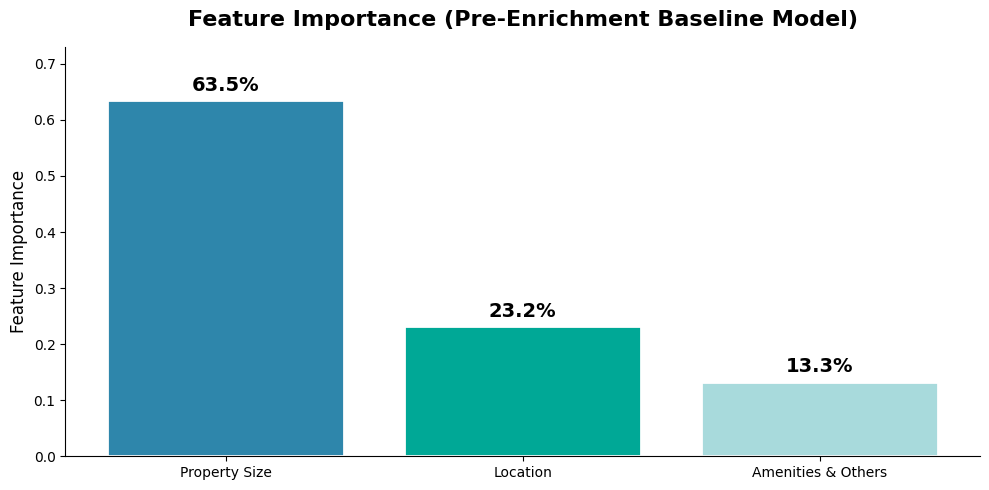

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Group features into categories
property_size = ['bedrooms', 'bathrooms', 'guests', 'beds']
location = ['lat', 'long']
# Everything else is amenities & others

property_size_sum = sum(importance_dict.get(f, 0) for f in property_size)
location_sum = sum(importance_dict.get(f, 0) for f in location)
amenities_others_sum = sum(v for k, v in importance_dict.items() 
                           if k not in property_size and k not in location)

# Data for plot
categories = ['Property Size', 'Location', 'Amenities & Others']
values = [property_size_sum, location_sum, amenities_others_sum]
colors = ['#2E86AB', '#00A896', '#A8DADC']  # Blue, Teal, Light gray-teal

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(categories, values, color=colors, edgecolor='white', linewidth=2, label=categories)

# Add percentage labels on bars
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val*100:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Styling
ax.set_ylabel('Feature Importance', fontsize=12)
ax.set_title('Feature Importance (Pre-Enrichment Baseline Model)', fontsize=16, fontweight='bold', pad=15)
ax.set_ylim(0, max(values) * 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
# ax.legend(categories, title="Feature Groups", loc="upper right", fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.show()

### Baseline Model Insights

With an **R² of 0.5092**, our baseline model explains approximately half of the price variance. The Feature Importance analysis highlights a clear limitation in using only internal structured data:

1.  **dominance of "Commodity" Metrics:**
    * The top features are exclusively size-related (`bedrooms`, `bathrooms`, `guests`, `beds`), accounting for over **63%** of the model's decision-making power.
    * `lat` and `long` are critical (3rd and 6th place), proving location matters, but raw coordinates lack semantic context (e.g., proximity to attractions).

2.  **The "Quality" Blind Spot:**
    * Crucial indicators of guest experience, such as `host_rating` (0.0073) and `amenities` (like WiFi or AC, <0.003), have negligible impact. The model currently treats a luxury apartment and a basic unit similarly if they share the same size and coordinates.

 This validates our next phase: **Data Enrichment**. We will inject external context (Walk Score, POI density) to capture the "premium" drivers that raw columns miss.

## Walk Score & POI Density Data Enrichment

In [0]:
if "df_imputed" not in locals() or df_imputed is None:
    df_imputed = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_imputed")

In [0]:
# Load POI data from workspace using pandas
import pandas as pd

poi_grid_df_pd = pd.read_csv("/Workspace/Users/mmeirovich@campus.technion.ac.il/poi_data/GLOBAL_MASTER_DATASET2.csv")
poi_df = spark.createDataFrame(poi_grid_df_pd)

In [0]:
# --- Step 1: City Aggregation ---
# We create a "dictionary" of average restaurants/stations for each grid in a given city
city_stats_df = poi_df.groupBy("city_name", "country_name").agg(
    F.mean("poi_restaurants").alias("city_avg_restaurants"),
    F.mean("poi_cafes").alias("city_avg_cafes"),
    F.mean("poi_transit_stops").alias("city_avg_transit"),
    F.mean("poi_bus_stops").alias("city_avg_bus_stops"),
    F.mean("poi_supermarkets").alias("city_avg_supermarkets"),
    F.mean("poi_total").alias("city_avg_total")

)

# --- Step 2: Existing Grid Logic ---
GRID_SIZE = 0.0045

def get_grid_index(col_name):
    return F.round(F.col(col_name) / GRID_SIZE).cast(LongType())

# Apply grid logic to listings (df_imputed)
df_imputed_grids = df_imputed.withColumn(
    "grid_lat_idx", get_grid_index("lat")
).withColumn(
    "grid_lon_idx", get_grid_index("long")
)

# Apply grid logic to POI data
poi_df_grids = poi_df.withColumn(
    "grid_lat_idx", get_grid_index("center_lat")
).withColumn(
    "grid_lon_idx", get_grid_index("center_lon")
)

# --- Step 3: The original join (Grid Match) ---
df_grid_joined = df_imputed_grids.join(
    F.broadcast(poi_df_grids.select(
        "grid_lat_idx", "grid_lon_idx",
        "poi_restaurants", "poi_cafes", "poi_transit_stops",
        "poi_bus_stops", "poi_supermarkets", "poi_total"
    )),
    on=["grid_lat_idx", "grid_lon_idx"],
    how="left"
)

# --- Step 4: Add the city data and fill in the gaps (Fallback Join) ---
# If the names in Airbnb are city and country, we will change them in the join

df_final = df_grid_joined.join(
    F.broadcast(city_stats_df),
    (F.lower(df_grid_joined.city) == F.lower(city_stats_df.city_name)) & 
    (F.lower(df_grid_joined.country) == F.lower(city_stats_df.country_name)),
    how="left"
).select(
    df_grid_joined["*"], # keep all original columns
    
    F.coalesce(F.col("poi_restaurants"), F.col("city_avg_restaurants"), F.lit(0)).alias("final_restaurants"),
    F.coalesce(F.col("poi_cafes"), F.col("city_avg_cafes"), F.lit(0)).alias("final_cafes"),
    F.coalesce(F.col("poi_transit_stops"), F.col("city_avg_transit"), F.lit(0)).alias("final_transit"),
    F.coalesce(F.col("poi_bus_stops"), F.col("city_avg_bus_stops"), F.lit(0)).alias("final_bus_stops"),
    F.coalesce(F.col("poi_supermarkets"), F.col("city_avg_supermarkets"), F.lit(0)).alias("final_supermarkets"),
    F.coalesce(F.col("poi_total"), F.col("city_avg_total"), F.lit(0)).alias("final_poi_total"),


    
    F.when(F.col("poi_total").isNotNull(), F.lit("exact_grid"))
     .when(F.col("city_avg_total").isNotNull(), F.lit("city_fallback"))
     .otherwise(F.lit("no_data")).alias("data_source_type")
)

df_final = df_final.drop("grid_lat_idx", "grid_lon_idx", "poi_restaurants", "poi_cafes", "poi_transit_stops", "poi_bus_stops", "poi_supermarkets", "poi_total")

df_final = df_final \
    .withColumnRenamed("final_restaurants", "poi_restaurants") \
    .withColumnRenamed("final_cafes", "poi_cafes") \
    .withColumnRenamed("final_transit", "poi_transit") \
    .withColumnRenamed("final_bus_stops", "poi_bus_stops") \
    .withColumnRenamed("final_supermarkets", "poi_supermarkets") \
    .withColumnRenamed("final_poi_total", "poi_total")

df_imputed.unpersist()
df_final.cache()

DataFrame[price: double, lat: double, long: double, guests: int, pets_allowed: int, property_id: string, is_supperhost: int, host_number_of_reviews: int, host_rating: double, hosts_year: int, host_response_rate: int, is_guest_favorite: int, property_number_of_reviews: int, seller_id: string, city: string, state: string, country: string, num_images: int, cancellation_type: string, log_price: double, bedrooms: int, beds: int, bathrooms: double, property_type: string, has_ac: int, has_wifi: int, has_pool: int, has_kitchen: int, has_parking: int, amenities_count: int, poi_restaurants: double, poi_cafes: double, poi_transit: double, poi_bus_stops: double, poi_supermarkets: double, poi_total: double, data_source_type: string]

In [0]:
# walk score
from pyspark.sql import functions as F

# =============================================================================
# IMPROVED WALKABILITY SCORE (Log-Based Diminishing Returns)
# =============================================================================
# Logic: We use Log(x + 1) to naturally handle diminishing returns.
# The first amenity gives the most points. The 10th gives very little.

# Constants for tuning
W_FOOD = 15.0       # Supermarket multiplier
W_TRANSIT = 12.0    # Transit multiplier
W_LIFESTYLE = 8.0   # Restaurant/Cafe multiplier

# 1. Supermarkets (Essentials)
score_supermarket = F.least(F.log1p(F.col("poi_supermarkets")) * W_FOOD, F.lit(30))

# 2. Public Transport (Connectivity)
# Summing stops first, then applying log
transit_total = F.coalesce(F.col("poi_transit"), F.lit(0)) + \
                F.coalesce(F.col("poi_bus_stops"), F.lit(0))
                
score_transit = F.least(F.log1p(transit_total) * W_TRANSIT, F.lit(30))

# 3. Lifestyle (Restaurants & Cafes)
# Lifestyle needs volume to be good, so we combine them
lifestyle_total = F.coalesce(F.col("poi_restaurants"), F.lit(0)) + \
                  F.coalesce(F.col("poi_cafes"), F.lit(0))

score_lifestyle = F.least(F.log1p(lifestyle_total) * W_LIFESTYLE, F.lit(40))

# 4. Final Score & Jitter
airbnb_enriched = df_final.withColumn(
    "raw_walk_score",
    score_supermarket + score_transit + score_lifestyle
).withColumn(
    "walk_score",
    F.round(F.least(F.col("raw_walk_score") + F.rand() * 2, F.lit(100)), 1)
).drop("raw_walk_score")


In [0]:
df_final.unpersist()
airbnb_enriched.cache()

DataFrame[price: double, lat: double, long: double, guests: int, pets_allowed: int, property_id: string, is_supperhost: int, host_number_of_reviews: int, host_rating: double, hosts_year: int, host_response_rate: int, is_guest_favorite: int, property_number_of_reviews: int, seller_id: string, city: string, state: string, country: string, num_images: int, cancellation_type: string, log_price: double, bedrooms: int, beds: int, bathrooms: double, property_type: string, has_ac: int, has_wifi: int, has_pool: int, has_kitchen: int, has_parking: int, amenities_count: int, poi_restaurants: double, poi_cafes: double, poi_transit: double, poi_bus_stops: double, poi_supermarkets: double, poi_total: double, data_source_type: string, walk_score: double]

In [0]:
# Check the distribution of the calculated Walk Score
display(airbnb_enriched.select("walk_score"))

walk_score
0.3
1.6
43.5
1.9
1.4
0.9
62.6
1.7
0.6
0.5


Databricks visualization. Run in Databricks to view.

## Hotel Competition Enrichment

Integrate Booking.com hotel data to capture competition signals per grid area.

In [0]:
booking_df = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/booking_df")

In [0]:
from pyspark.sql import functions as F

# -------------------------------------------------------------------------
# STEP 1: DEFINE GRID SIZE
# -------------------------------------------------------------------------
# You need to use the SAME grid step used to create 'grid_lat_idx' in airbnb_df.
# If grid_lat_idx = floor(lat / 0.005), then GRID_STEP = 0.005.
# If you don't know it, you can infer it from the airbnb data, or set it (e.g., ~500m).
COMMON_GRID_STEP = 0.005  # ~500m  # roughly 500 meters at most latitudes

# -------------------------------------------------------------------------
# STEP 2: PREPARE BOOKING DATA
# -------------------------------------------------------------------------
# We extract coordinates, create the grid indices, and filter out invalid rows.

airbnb_regrid = airbnb_enriched.withColumn(
    "new_grid_lat", (F.col("lat") / COMMON_GRID_STEP).cast("long")
).withColumn(
    "new_grid_lon", (F.col("long") / COMMON_GRID_STEP).cast("long")
)

booking_regrid = booking_df.filter(F.col("coordinates").isNotNull()) \
    .withColumn("lat", F.col("coordinates.lan")) \
    .withColumn("lon", F.col("coordinates.lon")) \
    .withColumn(
        "new_grid_lat", (F.col("lat") / COMMON_GRID_STEP).cast("long")
    ).withColumn(
        "new_grid_lon", (F.col("lon") / COMMON_GRID_STEP).cast("long")
    )

# -------------------------------------------------------------------------
# STEP 3: AGGREGATE BOOKING STATS
# -------------------------------------------------------------------------
# Instead of joining millions of rows, we aggregate to the grid level first.
booking_stats = booking_regrid.groupBy("new_grid_lat", "new_grid_lon") \
    .agg(
        F.count("*").alias("booking_hotel_count"),
        F.avg("review_score").alias("booking_avg_rating"),
        F.sum("number_of_reviews").alias("booking_total_reviews")
    )

# -------------------------------------------------------------------------
# STEP 4: JOIN WITH AIRBNB DATA
# -------------------------------------------------------------------------
# Use a Left Join to keep all Airbnb listings.
# We broadcast booking_stats because the aggregated grid table is usually small.
final_df = airbnb_regrid.join(
    F.broadcast(booking_stats), 
    on=["new_grid_lat", "new_grid_lon"], 
    how="left"
).fillna({
    "booking_hotel_count": 0,
    "booking_avg_rating": 0.0,
    "booking_total_reviews": 0
})

In [0]:
city_stats = final_df.filter(F.col("booking_hotel_count") > 0) \
    .groupBy("city") \
    .agg(
        F.avg("booking_hotel_count").alias("city_avg_hotel_count"),
        F.avg("booking_avg_rating").alias("city_avg_rating"),
        F.avg("booking_total_reviews").alias("city_avg_reviews")
    )

df_with_city_stats = final_df.join(
    F.broadcast(city_stats),
    on="city",
    how="left"
)

final_enriched_df = df_with_city_stats.withColumn(
    "booking_data_source",
    F.when(F.col("booking_hotel_count") > 0, F.lit("exact_grid"))  # נתון אמיתי ומדויק
     .when(F.col("city_avg_hotel_count").isNotNull(), F.lit("city_avg")) # השלמה לפי עיר
     .otherwise(F.lit("none")) # אין מידע גם בעיר (נדיר)
).withColumn(
    "booking_hotel_count",
    F.when(F.col("booking_hotel_count") > 0, F.col("booking_hotel_count"))
     .otherwise(F.coalesce(F.col("city_avg_hotel_count"), F.lit(0)))
).withColumn(
    "booking_avg_rating",
    F.when(F.col("booking_hotel_count") > 0, F.col("booking_avg_rating"))
     .otherwise(F.coalesce(F.col("city_avg_rating"), F.lit(0)))
).withColumn(
    "booking_total_reviews",
    F.when(F.col("booking_hotel_count") > 0, F.col("booking_total_reviews"))
     .otherwise(F.coalesce(F.col("city_avg_reviews"), F.lit(0)))
).drop("city_avg_hotel_count", "city_avg_rating", "city_avg_reviews", "new_grid_lat", "new_grid_lon")

In [0]:
from pyspark.sql import functions as F

total_listings = final_enriched_df.count()
enriched_listings = final_enriched_df.filter(F.col("booking_hotel_count") > 0).count()
coverage_pct = (enriched_listings / total_listings) * 100

print(f"Total Airbnb Listings: {total_listings:,}")
print(f"Listings Enriched with Booking Data: {enriched_listings:,}")
print(f"Coverage Rate: {coverage_pct:.2f}%")

Total Airbnb Listings: 1,348,175
Listings Enriched with Booking Data: 1,298,813
Coverage Rate: 96.34%


In [0]:
airbnb_enriched.unpersist()
final_enriched_df.cache()

DataFrame[city: string, price: double, lat: double, long: double, guests: int, pets_allowed: int, property_id: string, is_supperhost: int, host_number_of_reviews: int, host_rating: double, hosts_year: int, host_response_rate: int, is_guest_favorite: int, property_number_of_reviews: int, seller_id: string, state: string, country: string, num_images: int, cancellation_type: string, log_price: double, bedrooms: int, beds: int, bathrooms: double, property_type: string, has_ac: int, has_wifi: int, has_pool: int, has_kitchen: int, has_parking: int, amenities_count: int, poi_restaurants: double, poi_cafes: double, poi_transit: double, poi_bus_stops: double, poi_supermarkets: double, poi_total: double, data_source_type: string, walk_score: double, booking_hotel_count: double, booking_avg_rating: double, booking_total_reviews: double, booking_data_source: string]

## Feature Engineering

In [0]:
# Property capacity ratio features
final_enriched_df = final_enriched_df.withColumn(
    "beds_per_bedroom",
    F.when(F.col("bedrooms") > 0, F.col("beds") / F.col("bedrooms")).otherwise(F.col("beds"))
).withColumn(
    "guests_per_bedroom",
    F.when(F.col("bedrooms") > 0, F.col("guests") / F.col("bedrooms")).otherwise(F.col("guests"))
).withColumn(
    "bathrooms_per_bedroom",
    F.when(F.col("bedrooms") > 0, F.col("bathrooms") / F.col("bedrooms")).otherwise(F.col("bathrooms"))
)


In [0]:
# Host quality composite score (normalized 0-1)
final_enriched_df = final_enriched_df.withColumn(
    "host_quality_score",
    (F.col("host_rating") / 5.0) * 0.4 +
    (F.col("host_response_rate") / 100.0) * 0.3 +
    (F.col("is_supperhost").cast("double")) * 0.3
)

In [0]:
# Review density (reviews per year of hosting)
final_enriched_df = final_enriched_df.withColumn(
    "reviews_per_year",
    F.when(F.col("hosts_year") > 0,
           F.col("property_number_of_reviews") / F.col("hosts_year"))
     .otherwise(F.col("property_number_of_reviews"))
)

In [0]:
# Amenity value features
final_enriched_df = final_enriched_df.withColumn(
    "amenities_per_guest",
    F.when(F.col("guests") > 0, F.col("amenities_count") / F.col("guests"))
     .otherwise(F.col("amenities_count"))
).withColumn(
    "premium_amenity_score",
    F.col("has_pool") + F.col("has_parking") + F.col("has_ac")
)

In [0]:
# Competitive Context

# Normalize hotel density (is this a strong tourist area?)
final_enriched_df = final_enriched_df.withColumn(
    "tourism_density",
    F.log1p(F.col("booking_hotel_count")) # Log transform because counts can be skewed
)

# Hotel Alternative Index - Are the hotels in the area good?
# If the hotels in the area are highly rated, the apartment needs to try harder to be attractive
final_enriched_df = final_enriched_df.withColumn(
    "local_hotel_competition_quality",
    F.col("booking_avg_rating") * F.log1p(F.col("booking_total_reviews"))
)


In [0]:
# Location "Vibe" Clusters (POI Aggregation)

# Lifestyle Scores
final_enriched_df = final_enriched_df.withColumn(
    "foodie_score",
    F.col("poi_restaurants") + F.col("poi_cafes")
).withColumn(
    "transport_score",
    F.col("poi_transit") + F.col("poi_bus_stops")
)

In [0]:
#save
final_enriched_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/Workspace/Users/mmeirovich@campus.technion.ac.il/final_enriched_df")

## Feature Selection

In [0]:
if "final_enriched_df" not in locals() or final_enriched_df is None:
    final_enriched_df = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/final_enriched_df")

### Correlation Analysis for Numerical Features

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

exclude_cols = ['property_id', 'seller_id', 'city', 'country', 'state']

numeric_cols = [c for c, t in final_enriched_df.dtypes 
                if t in ['int', 'double', 'long', 'float'] 
                and c not in exclude_cols + ['log_price', 'price']]

In [0]:
correlations_log_price = []
correlations_price = []
for col in numeric_cols:
    corr_log_price = final_enriched_df.stat.corr(col, 'log_price')
    correlations_log_price.append((col, corr_log_price))
    corr_price = final_enriched_df.stat.corr(col, 'price')
    correlations_price.append((col, corr_price))

corr_log_price_df = pd.DataFrame(correlations_log_price, columns=['feature', 'correlation'])
corr_log_price_df['abs_corr'] = corr_log_price_df['correlation'].abs()
corr_log_price_df = corr_log_price_df.sort_values('abs_corr', ascending=False)

corr_price_df = pd.DataFrame(correlations_price, columns=['feature', 'correlation'])
corr_price_df['abs_corr'] = corr_price_df['correlation'].abs()
corr_price_df = corr_price_df.sort_values('abs_corr', ascending=False)

corr_log_price_df = pd.DataFrame(correlations_log_price, columns=['Feature', 'Log_Price_Corr'])
corr_price_df = pd.DataFrame(correlations_price, columns=['Feature', 'Price_Corr'])

merged_df = pd.merge(corr_log_price_df, corr_price_df, on='Feature')
merged_df['Max_Abs_Corr'] = merged_df[['Log_Price_Corr', 'Price_Corr']].abs().max(axis=1)

final_table = merged_df.sort_values('Max_Abs_Corr', ascending=False).drop(columns=['Max_Abs_Corr']).head(20)

In [0]:
final_table

,Feature,Log_Price_Corr,Price_Corr
2,guests,0.495065,0.499691
14,bathrooms,0.393782,0.438592
13,beds,0.381413,0.405013
12,bedrooms,0.381413,0.405013
20,amenities_count,0.306363,0.252430
0,lat,0.272450,0.179570
11,num_images,0.269690,0.264878
36,amenities_per_guest,-0.227393,-0.227211
17,has_pool,0.209718,0.218237
37,premium_amenity_score,0.212795,0.202967


### Feature Importance from Random Forest

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = assembler.transform(final_enriched_df.na.drop(subset=numeric_cols + ['price', 'log_price']))

rf_log_price = RandomForestRegressor(featuresCol="features", labelCol="log_price", 
                           numTrees=50, maxDepth=10, seed=42)
model_log_price = rf_log_price.fit(df_assembled)

rf_price = RandomForestRegressor(featuresCol="features", labelCol="price", 
                           numTrees=50, maxDepth=10, seed=42)
model_price = rf_price.fit(df_assembled)

# Feature importance - log price
print("Feature importance - log price:")
importance_log_price = list(zip(numeric_cols, model_log_price.featureImportances.toArray()))
importance_log_price_df = pd.DataFrame(importance_log_price, columns=['feature', 'importance'])
importance_log_price_df = importance_log_price_df.sort_values('importance', ascending=False)
print(importance_log_price_df.head(20))

# Feature importance - price
print("Feature importance -  price:")
importance_price = list(zip(numeric_cols, model_price.featureImportances.toArray()))
importance_price_df = pd.DataFrame(importance_price, columns=['feature', 'importance'])
importance_price_df = importance_price_df.sort_values('importance', ascending=False)
print(importance_price_df.head(20))

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run resilient-dolphin-94 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/1468a1f40ee64218b928806e92b87258
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run youthful-boar-491 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/026287b5536f44ab858f697c7bf0d513
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
Feature importance - log price:
                       feature  importance
0                          lat    0.230317
14                   bathrooms    0.173127
2                       guests    0.162294
12                    bedrooms    0.109669
1                         long    0.098972
13                        beds    0.088051
17                    has_pool    0.022795
32          guests_per_bedroom    0.021968
11                  num_images    0.020472
33       bathrooms_per_bedroom    0.017233
20             amenities_count    0.011864
37       premium_amenity_score    0.008868
35            reviews_per_year    0.004550
36         amenities_per_guest    0.002895
5       host_number_of_reviews    0.002243
30       booking_tota

### Multicollinearity test

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import pyspark.sql.functions as F

clean_df = final_enriched_df.select(numeric_cols).na.drop()

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_vector = assembler.transform(clean_df).select("corr_features")

matrix = Correlation.corr(df_vector, "corr_features").head()
corr_matrix = matrix[0].toArray()

pdf_corr = pd.DataFrame(corr_matrix, columns=numeric_cols, index=numeric_cols)

high_corr_pairs = []

for i in range(len(pdf_corr.columns)):
    for j in range(i + 1, len(pdf_corr.columns)):
        val = pdf_corr.iloc[i, j]
        if abs(val) > 0.8: # 
            col1 = pdf_corr.columns[i]
            col2 = pdf_corr.columns[j]
            high_corr_pairs.append((col1, col2, val))

print("Highly correlated pairs (> 0.8):")
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for c1, c2, val in high_corr_pairs:
    print(f"  {c1:30} <-> {c2:30}: {val:.3f}")

Highly correlated pairs (> 0.8):
  bedrooms                       <-> beds                          : 1.000
  poi_restaurants                <-> foodie_score                  : 0.987
  poi_total                      <-> foodie_score                  : 0.965
  poi_restaurants                <-> poi_total                     : 0.947
  poi_cafes                      <-> foodie_score                  : 0.920
  poi_bus_stops                  <-> transport_score               : 0.918
  is_supperhost                  <-> host_quality_score            : 0.909
  poi_transit                    <-> transport_score               : 0.904
  poi_cafes                      <-> poi_total                     : 0.901
  walk_score                     <-> transport_score               : 0.851
  poi_bus_stops                  <-> walk_score                    : 0.847
  poi_restaurants                <-> poi_cafes                     : 0.844
  booking_avg_rating             <-> local_hotel_competition_qualit

### Feature Selection Analysis

**Correlation Analysis:** Property size features (`guests`, `bathrooms`, `bedrooms`) show strongest correlation with price . Location coordinates show moderate correlation. External enrichment features show weak correlation.

**Random Forest Importance:** Coordinates (`lat`, `long`) account for ~33% of importance. Property size features contribute ~54%. External data (POI, walk_score, booking) contributes <3% combined—coordinates already encode location quality implicitly.

**Multicollinearity (>0.8):** To reduce noise and dimensionality, we are removing highly correlated features:
* **Drop `beds`:** It has a correlation of **1.000** with `bedrooms`. We will keep `bedrooms` as the standard metric.
* **Drop Raw POI Counts:** `poi_restaurants`, `poi_cafes`, and `poi_bus_stops` are highly correlated (>0.9) with our engineered scores (`foodie_score`, `transport_score`) and `poi_total`. **Decision:** Keep only the aggregated `poi_total` and the engineered `score` features, dropping the raw counts.
* **Drop `is_superhost`:** It is 91% correlated with our calculated `host_quality_score`. We will keep the continuous `host_quality_score` as it captures more nuance.

In [0]:
features_to_remove = exclude_cols + [
    'beds',  # keep bedrooms (more interpretable)
    'is_supperhost',  # keep host_quality_score (more comprehensive)
    
    # POI: keep only aggregated versions
    'poi_restaurants',
    'poi_cafes', 
    'poi_bus_stops',
] 

final_enriched_df = final_enriched_df.drop(*features_to_remove)

## Preparation for training
Categorical Encoding, Vector Assembly and Scaling

In [0]:
# Categorical Encoding

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

categorical_cols = [c for c, t in final_enriched_df.dtypes if t in ['string']]

numeric_cols = [c for c, t in final_enriched_df.dtypes 
                if t in ['int', 'double', 'long', 'float'] 
                and c not in exclude_cols + ['log_price', 'price']]

# Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
    for col in categorical_cols
]

# Create pipeline for indexing
indexing_pipeline = Pipeline(stages=indexers)
indexing_model = indexing_pipeline.fit(final_enriched_df)
df_indexed = indexing_model.transform(final_enriched_df)

# Get indexed column names
indexed_categorical_cols = [f"{col}_indexed" for col in categorical_cols]

df_indexed = df_indexed.drop(*categorical_cols)
feature_cols = numeric_cols + indexed_categorical_cols
existing_cols = [col for col in feature_cols if col in df_indexed.columns]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run vaunted-cat-937 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/ad8f94c465584fdb88d6a10174448496
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


In [0]:
#save
df_indexed.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_indexed")

In [0]:
print("existing_cols = [")
for col in existing_cols:
    print(f"    '{col}',")
print("]")

existing_cols = [
    'lat',
    'long',
    'guests',
    'pets_allowed',
    'host_number_of_reviews',
    'host_rating',
    'hosts_year',
    'host_response_rate',
    'is_guest_favorite',
    'property_number_of_reviews',
    'num_images',
    'bedrooms',
    'bathrooms',
    'has_ac',
    'has_wifi',
    'has_pool',
    'has_kitchen',
    'has_parking',
    'amenities_count',
    'poi_transit',
    'poi_supermarkets',
    'poi_total',
    'walk_score',
    'booking_hotel_count',
    'booking_avg_rating',
    'booking_total_reviews',
    'beds_per_bedroom',
    'guests_per_bedroom',
    'bathrooms_per_bedroom',
    'host_quality_score',
    'reviews_per_year',
    'amenities_per_guest',
    'premium_amenity_score',
    'tourism_density',
    'local_hotel_competition_quality',
    'foodie_score',
    'transport_score',
    'cancellation_type_indexed',
    'property_type_indexed',
    'data_source_type_indexed',
]


In [0]:
# Vector Assembly

from pyspark.ml.feature import VectorAssembler

assembler_full = VectorAssembler(
    inputCols=existing_cols,
    outputCol="features",
    handleInvalid="skip"
)

df_assembled = assembler_full.transform(df_indexed)
df_assembled = df_assembled.select("features", "price", "log_price")

In [0]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="features_scaled",
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_assembled)
df_modeling = scaler_model.transform(df_assembled)

df_modeling = df_modeling.select(
    "features",              # For RF, GBT
    "features_scaled",       # For Linear Regression
    "price",
    "log_price"
)

🏃 View run worried-crow-95 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/7382dcc0f560422993c7d6e58e8d3a10
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597


In [0]:
final_enriched_df.unpersist()
df_modeling.cache()

DataFrame[features: vector, features_scaled: vector, price: double, log_price: double]

In [0]:
df_modeling.columns

['features', 'features_scaled', 'price', 'log_price']

In [0]:
#save
df_modeling.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_modeling")

## Train/Test Split


In [0]:
if "df_modeling" not in locals() or df_modeling is None:
    df_modeling = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_modeling")
    df_modeling.cache()
    df_modeling.count()

In [0]:
# 80/20 train/test split
train_df, test_df = df_modeling.randomSplit([0.8, 0.2], seed=42)

# Spark optimization: Repartition based on cluster size
# Rule: 2-4x total cores (your cluster: 16 cores → 32-64 partitions)
num_partitions = max(sc.defaultParallelism * 2, 32)  # Auto-detect, minimum 32

train_df = train_df.repartition(num_partitions)
test_df = test_df.repartition(max(num_partitions // 4, 8))  # Smaller for test set

# Cache both splits
train_df.cache()
test_df.cache()
df_modeling.unpersist()

train_count = train_df.count()
test_count = test_df.count()

print(f"Train set: {train_count:,} records ({train_count/(train_count+test_count)*100:.1f}%)")
print(f"Test set: {test_count:,} records ({test_count/(train_count+test_count)*100:.1f}%)")
print(f"Train partitions: {train_df.rdd.getNumPartitions()} (optimized for {sc.defaultParallelism} cores)")

Train set: 1,078,812 records (80.0%)
Test set: 269,353 records (20.0%)
Train partitions: 32 (optimized for 4 cores)


## Training

In [0]:
from pyspark.ml.regression import RandomForestRegressor
import time

def train_rf(features_col, label_col, train_data, num_trees=100, max_depth=12, max_bins=64, cache_nodeIds=True, max_memor_in_MB=512):
    print("Training Random Forest")
    print(f"features columns: {features_col} | target variable: {label_col}")
    start_time = time.time()

    rf = RandomForestRegressor(
        featuresCol=features_col,
        labelCol=label_col,
        numTrees=num_trees,
        maxDepth=max_depth,
        maxBins=max_bins,     
        cacheNodeIds=cache_nodeIds,     
        maxMemoryInMB=max_memor_in_MB,
        seed=42
    )

    random_forest_model = rf.fit(train_data)
    training_time_rf = time.time() - start_time

    print(f"Random Forest training completed in {training_time_rf:.2f} seconds")
    print(f"Number of trees: {random_forest_model.getNumTrees}")

    return random_forest_model

In [0]:
from pyspark.ml.regression import GBTRegressor
import time

def train_gbt(features_col, label_col, train_data, max_iter=50, max_depth=5, max_bins=64, max_mem_in_MB=512):
    print("Training Gradient-Boosted Trees Regressor")
    print(f"features columns: {features_col} | target variable: {label_col}")
    start_time = time.time()

    gbt = GBTRegressor(
        featuresCol=features_col,
        labelCol=label_col,
        maxIter=max_iter,
        maxDepth=max_depth,
        maxBins=max_bins,
        maxMemoryInMB=max_mem_in_MB,
        seed=42
    )

    gbt_model = gbt.fit(train_data)
    training_time_gbt = time.time() - start_time

    print(f"GBT training completed in {training_time_gbt:.2f} seconds")
    print(f"Number of iterations: {gbt_model.getMaxIter()}")

    return gbt_model

In [0]:
from pyspark.ml.regression import LinearRegression
import time

def train_linear_regression(features_col, label_col, train_data, max_iter=100, reg_param=0.0, elastic_net_param=0.0):
    print("Training Linear Regression")
    print(f"features columns: {features_col} | target variable: {label_col}")
    start_time = time.time()

    lr = LinearRegression(
        featuresCol=features_col,
        labelCol=label_col,
        maxIter=max_iter,
        regParam=reg_param,
        elasticNetParam=elastic_net_param
    )

    lr_model = lr.fit(train_data)
    training_time_lr = time.time() - start_time

    print(f"Linear Regression training completed in {training_time_lr:.2f} seconds")

    return lr_model

In [0]:
lr_model = train_linear_regression("features_scaled", "log_price", train_df.select("features_scaled", "log_price"))

Training Linear Regression
features columns: features_scaled | target variable: log_price


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run big-cod-965 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/8f85ae0c8b914f9fa2eae31800926f37
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
Linear Regression training completed in 69.28 seconds


In [0]:
rf_model = train_rf("features", "price", train_df.select("features", "price"))

Training Random Forest
features columns: features | target variable: price


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run loud-dolphin-231 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/91d7bd1c112d4b69bcc5b0f6080c03f7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
Random Forest training completed in 611.29 seconds
Number of trees: 100


In [0]:
rf_model_log_price = train_rf("features", "log_price", train_df.select("features", "log_price"))

Training Random Forest
features columns: features | target variable: log_price


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run legendary-yak-272 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/60accd8fb12b45599ff23c506a50e9d3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
Random Forest training completed in 474.32 seconds
Number of trees: 100


In [0]:
gbt_model = train_gbt("features", "price", train_df.select("features", "price"))

Training Gradient-Boosted Trees Regressor
features columns: features | target variable: price


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run painted-calf-445 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/8d635de6345642548e4a45976f740c1f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
GBT training completed in 240.41 seconds
Number of iterations: 50


In [0]:
gbt_model_log_price = train_gbt("features", "log_price", train_df.select("features", "log_price"))

Training Gradient-Boosted Trees Regressor
features columns: features | target variable: log_price


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run upbeat-slug-347 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/e51eb24ecc6c4ce48ecb365ae0549874
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
GBT training completed in 279.93 seconds
Number of iterations: 50


In [0]:
base_path = "dbfs:/FileStore/airbnb_project/models/"

print(f"Saving models to {base_path}...")

# 1. Linear Regression
lr_model.write().overwrite().save(base_path + "lr_model_log")

# 2. Random Forest
rf_model.write().overwrite().save(base_path + "rf_model_price")
rf_model_log_price.write().overwrite().save(base_path + "rf_model_log")

# 3. GBT
gbt_model.write().overwrite().save(base_path + "gbt_model_price")
gbt_model_log_price.write().overwrite().save(base_path + "gbt_model_log")

print("✅ All models saved successfully! You can safely close the cluster.")

Saving models to dbfs:/FileStore/airbnb_project/models/...
✅ All models saved successfully! You can safely close the cluster.


## Evaluation & Model Comparison

In [0]:
from pyspark.ml.regression import LinearRegressionModel, RandomForestRegressionModel, GBTRegressionModel

base_path = "dbfs:/FileStore/airbnb_project/models/"

lr_model = LinearRegressionModel.load(base_path + "lr_model_log")

rf_model = RandomForestRegressionModel.load(base_path + "rf_model_price")
rf_model_log_price = RandomForestRegressionModel.load(base_path + "rf_model_log")

gbt_model = GBTRegressionModel.load(base_path + "gbt_model_price")
gbt_model_log_price = GBTRegressionModel.load(base_path + "gbt_model_log")

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import exp, col

def evaluate_model(model, test_data, features_col="features", label_col="price", prediction_col="prediction"):
    """
    Evaluate model - always returns metrics on original price scale for comparability.
    """
    predictions = model.transform(test_data)
    
    # Determine which columns to use for evaluation
    if label_col == "log_price":
        # Convert log predictions back to price scale
        predictions = predictions.withColumn("price_pred", exp(col(prediction_col)))
        eval_label_col = "price"  # Compare against original price
        eval_pred_col = "price_pred"
    else:
        eval_label_col = "price"
        eval_pred_col = prediction_col
    
    # All metrics computed on original price scale
    evaluator_r2 = RegressionEvaluator(labelCol=eval_label_col, predictionCol=eval_pred_col, metricName="r2")
    evaluator_rmse = RegressionEvaluator(labelCol=eval_label_col, predictionCol=eval_pred_col, metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=eval_label_col, predictionCol=eval_pred_col, metricName="mae")
    
    metrics = {
        "r2": evaluator_r2.evaluate(predictions),
        "rmse": evaluator_rmse.evaluate(predictions),
        "mae": evaluator_mae.evaluate(predictions)
    }
    
    return predictions, metrics

In [0]:
lr_predictions, lr_metrics = evaluate_model(lr_model, test_df, features_col='features_scaled', label_col="log_price")
rf_predictions_price, rf_metrics_price = evaluate_model(rf_model, test_df, label_col="price")
rf_predictions_log_price, rf_metrics_log_price = evaluate_model(rf_model_log_price, test_df, label_col="log_price")
gbt_predictions_price, gbt_metrics_price = evaluate_model(gbt_model, test_df, label_col="price")
gbt_predictions_log_price, gbt_metrics_log_price = evaluate_model(gbt_model_log_price, test_df, label_col="log_price")

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F

data = [
    ("Linear Regression", "log_price", lr_metrics['r2'], lr_metrics['rmse'], lr_metrics['mae']),
    ("Random Forest", "price", rf_metrics_price['r2'], rf_metrics_price['rmse'], rf_metrics_price['mae']),
    ("Random Forest", "log_price", rf_metrics_log_price['r2'], rf_metrics_log_price['rmse'], rf_metrics_log_price['mae']),
    ("Gradient Boosting", "price", gbt_metrics_price['r2'], gbt_metrics_price['rmse'], gbt_metrics_price['mae']),
    ("Gradient Boosting", "log_price", gbt_metrics_log_price['r2'], gbt_metrics_log_price['rmse'], gbt_metrics_log_price['mae'])
]

schema = StructType([
    StructField("Model", StringType(), False),
    StructField("Target_Variable", StringType(), False),
    StructField("R2", DoubleType(), False),
    StructField("RMSE", DoubleType(), False),
    StructField("MAE", DoubleType(), False)
])

metrics_df = spark.createDataFrame(data, schema)

metrics_df_styled = metrics_df.select(
    "Model",
    "Target_Variable",
    F.round("R2", 4).alias("R2"),
    F.round("RMSE", 4).alias("RMSE"),
    F.round("MAE", 4).alias("MAE")
).orderBy(F.col("RMSE").desc())

display(metrics_df_styled)

Model,Target_Variable,R2,RMSE,MAE
Linear Regression,log_price,0.2936,122.1007,75.6028
Random Forest,log_price,0.4775,105.0117,64.9132
Gradient Boosting,log_price,0.5016,102.558,63.8159
Random Forest,price,0.5207,100.5773,67.0856
Gradient Boosting,price,0.5219,100.4484,66.736


Databricks visualization. Run in Databricks to view.

### Model Comparison Results

**Selected model for tuning:** GBT (price) - best R² and RMSE performance.

## hyperparameter tuning 

In [0]:
train_df.columns

['features', 'price', 'log_price', 'features_no_coords', 'features_scaled']

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
import mlflow
import mlflow.spark

# Define GBT model
gbt = GBTRegressor(featuresCol="features", labelCol="price", seed=42)

# Parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [100, 150]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

# Evaluator
evaluator = RegressionEvaluator(
    labelCol="price", 
    predictionCol="prediction", 
    metricName="rmse"
)

# Cross Validator
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

# Train
print(f"Training {len(paramGrid)} parameter combinations with 3-fold CV...")
cv_model = cv.fit(train_df.select("features", "price"))

model_path = "dbfs:/FileStore/airbnb_project/models/gbt_hyperopt_best"
cv_model.bestModel.write().overwrite().save(model_path)
print(f"💾 Saved the best model to: {model_path}")

Training 8 parameter combinations with 3-fold CV...
🏃 View run handsome-ant-96 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/eb12056bcdf84d7fb1ca8a4ad21a7bef
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
🏃 View run intrigued-fly-576 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/4b241c4ad1e6428699336dffecaece3b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
🏃 View run nebulous-sponge-769 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/aebd17096345447dbfae8db8496c4b57
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
🏃 View run upbeat-wren-809 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/e72e7b6d29674f32a2967536927aa9c1
🧪 View experiment a

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run puzzled-squid-831 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/84f56256cec34706853cb9e311699b12
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
💾 Saved the best model to: dbfs:/FileStore/airbnb_project/models/gbt_hyperopt_best


In [0]:
# Best model
best_gbt = cv_model.bestModel

# Print best parameters
print("\nBest Parameters:")
print(f"  maxDepth: {best_gbt.getOrDefault('maxDepth')}")
print(f"  maxIter: {best_gbt.getOrDefault('maxIter')}")
print(f"  stepSize: {best_gbt.getOrDefault('stepSize')}")

# Evaluate on test set
best_predictions, best_metrics = evaluate_model(best_gbt, test_df, label_col="price")
print(f"\nTuned GBT Performance:")
print(f"  R²:   {best_metrics['r2']:.4f}")
print(f"  RMSE: {best_metrics['rmse']:.2f}")
print(f"  MAE:  {best_metrics['mae']:.2f}")


Best Parameters:
  maxDepth: 10
  maxIter: 150
  stepSize: 0.1

Tuned GBT Performance:
  R²:   0.6019
  RMSE: $91.66
  MAE:  $59.82


## Resulst Analysis

In [0]:
from pyspark.ml.regression import GBTRegressionModel

best_gbt = GBTRegressionModel.load("dbfs:/FileStore/airbnb_project/models/gbt_hyperopt_best")
best_predictions, best_metrics = evaluate_model(best_gbt, test_df, label_col="price")

In [0]:
def print_feature_importance(model, cols):
    importance = model.featureImportances.toArray()
    importance_dict = dict(zip(cols, importance))
    importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    print("Feature Importance:")
    for i, (feat, imp) in enumerate(importance_sorted, 1):
        print(f"{i:2d}. {feat:30s}: {imp:.4f}")

In [0]:
print_feature_importance(best_gbt, existing_cols)

Feature Importance:
 1. lat                           : 0.1362
 2. long                          : 0.1218
 3. bathrooms                     : 0.1143
 4. host_number_of_reviews        : 0.0510
 5. bedrooms                      : 0.0458
 6. guests                        : 0.0386
 7. host_rating                   : 0.0348
 8. booking_hotel_count           : 0.0343
 9. reviews_per_year              : 0.0341
10. amenities_count               : 0.0333
11. num_images                    : 0.0307
12. hosts_year                    : 0.0300
13. property_number_of_reviews    : 0.0231
14. host_quality_score            : 0.0220
15. amenities_per_guest           : 0.0216
16. bathrooms_per_bedroom         : 0.0200
17. booking_total_reviews         : 0.0196
18. guests_per_bedroom            : 0.0183
19. booking_avg_rating            : 0.0168
20. walk_score                    : 0.0163
21. has_pool                      : 0.0131
22. local_hotel_competition_quality: 0.0130
23. cancellation_type_indexed    

In [0]:
from pyspark.sql import functions as F

# Calculate difference
df_diff = best_predictions.select(
    'price',
    'prediction',
    (F.col('price') - F.col('prediction')).alias('difference'),
    ((F.col('price') - F.col('prediction')) / F.col('prediction') * 100).alias('diff_pct')  # as percentage
)

# Get statistics
stats_diff = df_diff.select(
    F.min('difference').alias('min'),
    F.max('difference').alias('max'),
    F.mean('difference').alias('mean'),
    F.stddev('difference').alias('std'),
    F.percentile_approx('difference', 0.01).alias('p1'),
    F.percentile_approx('difference', 0.05).alias('p5'),
    F.percentile_approx('difference', 0.25).alias('p25'),
    F.percentile_approx('difference', 0.50).alias('median'),
    F.percentile_approx('difference', 0.75).alias('p75'),
    F.percentile_approx('difference', 0.95).alias('p95'),
    F.percentile_approx('difference', 0.99).alias('p99')
)

stats_row = stats_diff.collect()[0]

print("=== Model Performance Statistics (Absolute Error) ===")
print(f"Min: {stats_row.min:.2f}")
print(f"Max: {stats_row.max:.2f}")
print(f"Mean: {stats_row.mean:.2f}")
print(f"Std: {stats_row.std:.2f}")
print(f"1st Percentile: {stats_row.p1:.2f}")
print(f"5th Percentile: {stats_row.p5:.2f}")
print(f"25th Percentile: {stats_row.p25:.2f}")
print(f"50th Percentile (Median): {stats_row.median:.2f}")
print(f"75th Percentile: {stats_row.p75:.2f}")
print(f"95th Percentile: {stats_row.p95:.2f}")
print(f"99th Percentile: {stats_row.p99:.2f}")
print("-" * 45)

# Same for percentage difference
stats_pct = df_diff.select(
    F.percentile_approx('diff_pct', 0.05).alias('p5_pct'),
    F.percentile_approx('diff_pct', 0.25).alias('p25_pct'),
    F.percentile_approx('diff_pct', 0.50).alias('median_pct'),
    F.percentile_approx('diff_pct', 0.75).alias('p75_pct'),
    F.percentile_approx('diff_pct', 0.95).alias('p95_pct')
)

stats_pct_row = stats_pct.collect()[0]

print("\n=== Percentage Difference Distribution ===")

print(f"5th Percentile: {stats_pct_row.p5_pct:.2f}%")
print(f"25th Percentile: {stats_pct_row.p25_pct:.2f}%")
print(f"50th Percentile (Median): {stats_pct_row.median_pct:.2f}%")
print(f"75th Percentile: {stats_pct_row.p75_pct:.2f}%")
print(f"95th Percentile: {stats_pct_row.p95_pct:.2f}%")
print("-" * 45)


=== Model Performance Statistics (Absolute Error) ===
Min: -730.22
Max: 822.74
Mean: -0.55
Std: 91.66
1st Percentile: -207.32
5th Percentile: -122.62
25th Percentile: -44.19
50th Percentile (Median): -10.53
75th Percentile: 27.18
95th Percentile: 161.51
99th Percentile: 338.63
---------------------------------------------

=== Percentage Difference Distribution ===
5th Percentile: -56.95%
25th Percentile: -31.98%
50th Percentile (Median): -9.30%
75th Percentile: 21.47%
95th Percentile: 93.43%
---------------------------------------------


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Calculate difference in PySpark
df_diff = best_predictions.select(
    'price',
    'prediction',
    (F.col('price') - F.col('prediction')).alias('difference')
)

# Filter to reasonable range and compute histogram in PySpark
min_diff = -150 # a little more that p5 (-122)
max_diff = 170 # a little more that p95 (161)
num_bins = 100
bin_width = (max_diff - min_diff) / num_bins

# Bucket the differences and count - all in PySpark
histogram_df = (
    df_diff
    .filter((F.col('difference') >= min_diff) & (F.col('difference') <= max_diff))
    .withColumn('bin', F.floor((F.col('difference') - min_diff) / bin_width).cast('int'))
    .groupBy('bin')
    .agg(F.count('*').alias('count'))
    .orderBy('bin')
)

# Calculate percentages for each category in PySpark
underpriced_threshold = -50 # approximate p25
overpriced_threshold = 30 # approximate p75

totals = df_diff.agg(
    F.count('*').alias('total'),
    F.sum(F.when(F.col('difference') < underpriced_threshold, 1).otherwise(0)).alias('underpriced'),
    F.sum(F.when((F.col('difference') >= underpriced_threshold) & (F.col('difference') <= overpriced_threshold), 1).otherwise(0)).alias('fair'),
    F.sum(F.when(F.col('difference') > overpriced_threshold, 1).otherwise(0)).alias('overpriced')
).collect()[0]

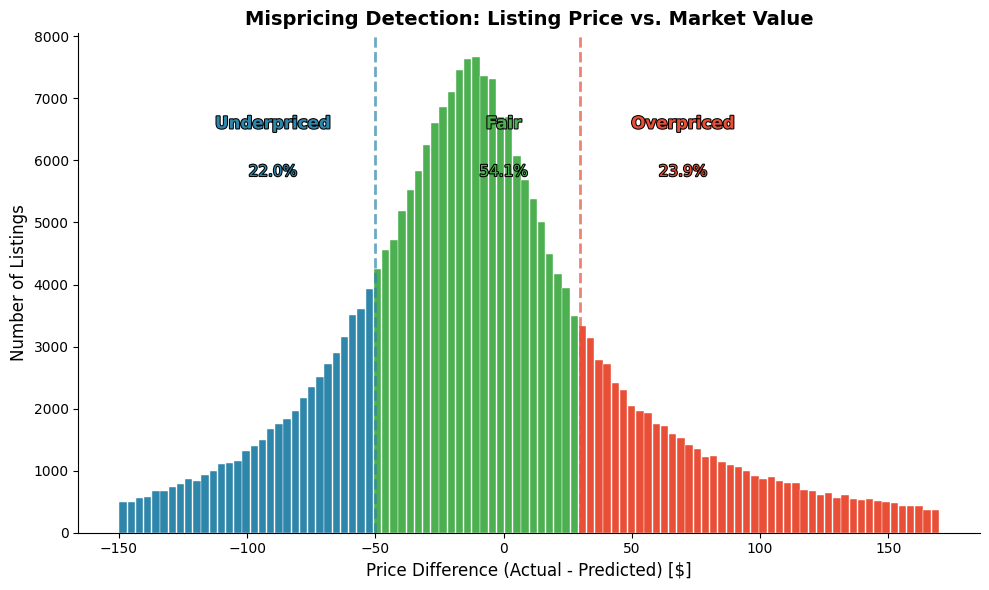

Underpriced: 22.0% | Fair: 54.1% | Overpriced: 23.9%


In [0]:
import matplotlib.patheffects as path_effects

total = totals['total']
underpriced_pct = (totals['underpriced'] / total) * 100
fair_pct = (totals['fair'] / total) * 100
overpriced_pct = (totals['overpriced'] / total) * 100

hist_pdf = histogram_df.toPandas()

# Create bin edges
bin_edges = np.linspace(min_diff, max_diff, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fill missing bins with 0
full_counts = np.zeros(num_bins)
for _, row in hist_pdf.iterrows():
    if 0 <= row['bin'] < num_bins:
        full_counts[int(row['bin'])] = row['count']

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Color bars based on thresholds
colors = []
for center in bin_centers:
    if center < underpriced_threshold:
        colors.append('#2E86AB')  # Blue - Underpriced
    elif center > overpriced_threshold:
        colors.append('#E94F37')  # Red - Overpriced
    else:
        colors.append('#4CAF50')  # Green - Fair

ax.bar(bin_centers, full_counts, width=bin_width * 0.9, color=colors, edgecolor='white', linewidth=0.3)

# Add vertical lines for thresholds
ax.axvline(x=underpriced_threshold, color='#2E86AB', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(x=overpriced_threshold, color='#E94F37', linestyle='--', linewidth=2, alpha=0.7)

# Add labels
outline = [path_effects.withStroke(linewidth=1.5, foreground='black')]
y_max = max(full_counts)
t1 = ax.text(underpriced_threshold - 40, y_max * 0.85, 'Underpriced', fontsize=12, fontweight='bold', color='#2E86AB', ha='center')
t2 = ax.text(0, y_max * 0.85, 'Fair', fontsize=12, fontweight='bold', color='#4CAF50', ha='center')
t3 = ax.text(overpriced_threshold + 40, y_max * 0.85, 'Overpriced', fontsize=12, fontweight='bold', color='#E94F37', ha='center')
t1.set_path_effects(outline)
t2.set_path_effects(outline)
t3.set_path_effects(outline)

# Add percentages
t4 = ax.text(underpriced_threshold - 40, y_max * 0.75, f'{underpriced_pct:.1f}%', fontsize=11, color='#2E86AB', ha='center')
t5 = ax.text(0, y_max * 0.75, f'{fair_pct:.1f}%', fontsize=11, color='#4CAF50', ha='center')
t6 = ax.text(overpriced_threshold + 40, y_max * 0.75, f'{overpriced_pct:.1f}%', fontsize=11, color='#E94F37', ha='center')
t4.set_path_effects(outline)
t5.set_path_effects(outline)
t6.set_path_effects(outline)

# Styling
ax.set_xlabel('Price Difference (Actual - Predicted) [$]', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
ax.set_title('Mispricing Detection: Listing Price vs. Market Value', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Underpriced: {underpriced_pct:.1f}% | Fair: {fair_pct:.1f}% | Overpriced: {overpriced_pct:.1f}%")

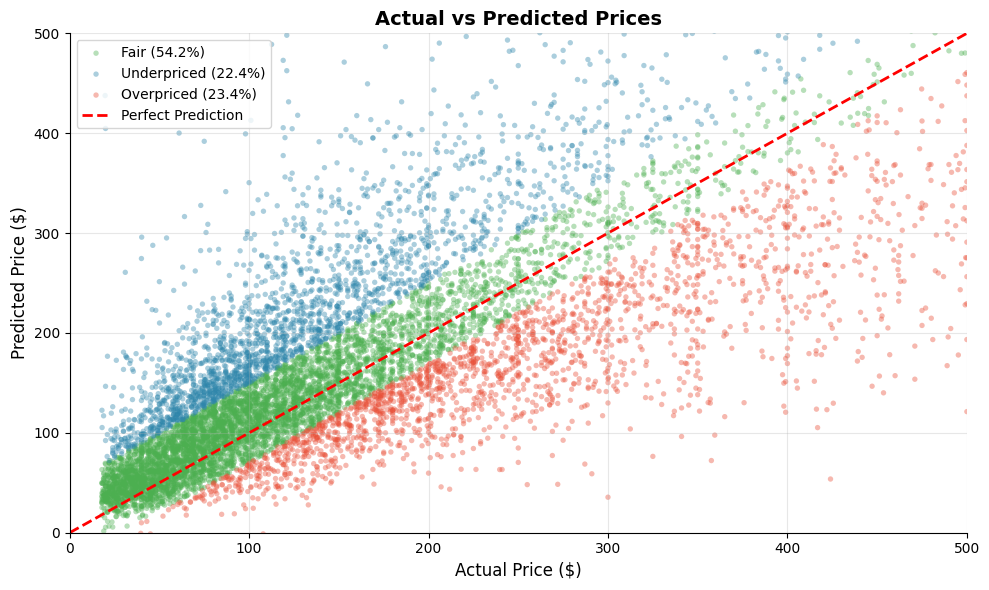

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Sample predictions for visualization
sample_size = 10000
predictions_sample = best_predictions.select("price", "prediction").sample(
    False, sample_size / best_predictions.count(), seed=42
).toPandas()

# Calculate difference and assign categories
predictions_sample['difference'] = predictions_sample['price'] - predictions_sample['prediction']

underpriced_threshold = -50 # approximate p25
overpriced_threshold = 30 # approximate p75

def get_category(diff):
    if diff < underpriced_threshold:
        return 'Underpriced'
    elif diff > overpriced_threshold:
        return 'Overpriced'
    else:
        return 'Fair'

predictions_sample['category'] = predictions_sample['difference'].apply(get_category)

# Color mapping (consistent with histogram)
colors = {
    'Underpriced': '#2E86AB',
    'Fair': '#4CAF50', 
    'Overpriced': '#E94F37'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each category separately for legend
for category in ['Fair', 'Underpriced', 'Overpriced']:
    mask = predictions_sample['category'] == category
    ax.scatter(
        predictions_sample.loc[mask, 'price'],
        predictions_sample.loc[mask, 'prediction'],
        alpha=0.4,
        s=15,
        c=colors[category],
        label=f'{category} ({mask.sum()/len(predictions_sample)*100:.1f}%)',
        edgecolors='none'
    )

# Perfect prediction line
ax.plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Price ($)', fontsize=12)
ax.set_ylabel('Predicted Price ($)', fontsize=12)
ax.set_title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

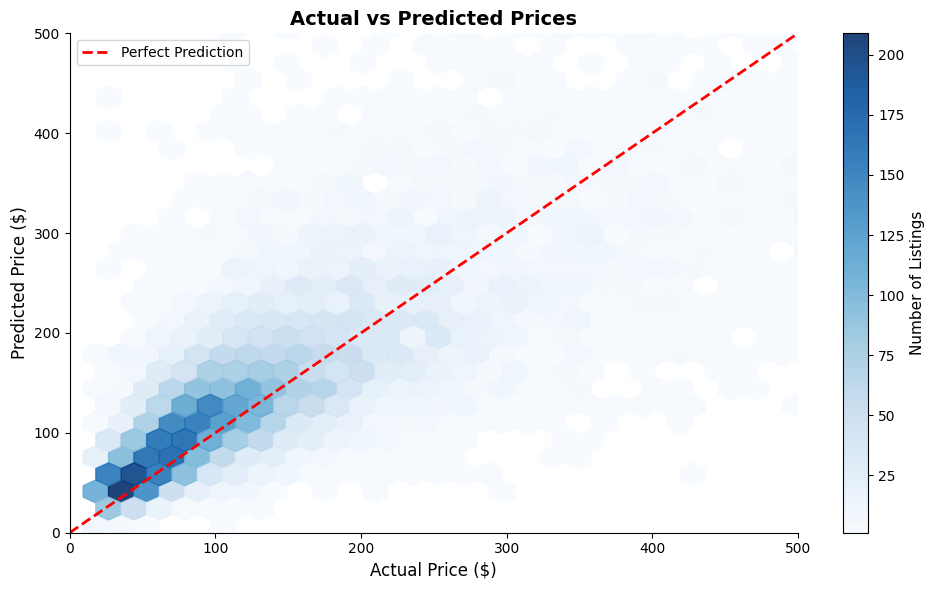

In [0]:
# The hexbin plot visualizes prediction accuracy concentration. Darker regions indicate higher listing density, showing where the model is most reliable.

import matplotlib.pyplot as plt
import numpy as np

# Sample predictions for visualization
sample_size = 10000
predictions_sample = best_predictions.select("price", "prediction").sample(
    False, sample_size / best_predictions.count(), seed=42
).toPandas()

fig, ax = plt.subplots(figsize=(10, 6))

# Hexbin density plot
hb = ax.hexbin(
    predictions_sample['price'], 
    predictions_sample['prediction'],
    gridsize=50,
    cmap='Blues',
    mincnt=1,
    alpha=0.9
)

# Perfect prediction line
ax.plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Prediction')

# Colorbar
cbar = plt.colorbar(hb, ax=ax)
cbar.set_label('Number of Listings', fontsize=11)

# Styling
ax.set_xlabel('Actual Price ($)', fontsize=12)
ax.set_ylabel('Predicted Price ($)', fontsize=12)
ax.set_title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.legend(loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Ablation Study: Impact of Data Enrichment Sources

To validate the value of our collected data, we perform an ablation study by training
models without specific feature groups and measuring the impact on prediction accuracy.


In [0]:
if "df_indexed" not in locals() or df_indexed is None:
    df_indexed = spark.read.format("delta").load("/Workspace/Users/mmeirovich@campus.technion.ac.il/df_indexed")

In [0]:
# def train_evaluate_model(df, feature_cols):
#     assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_ablation")
#     df_assembled = assembler.transform(df)
#     train_abl, test_abl = df_assembled.randomSplit([0.8, 0.2], seed=42)

#     model_abl = train_gbt("features_ablation", "price", train_abl, max_iter=50, max_depth=10)

#     predictions_abl, metrics_abl = evaluate_model(model_abl, test_abl, label_col="price")

#     return model_abl, predictions_abl, metrics_abl

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

print("ABLATION STUDY: Impact of Data Enrichment")
print("=" * 60)

# === SPLIT ONCE AND CACHE ===
train_abl, test_abl = df_indexed.randomSplit([0.8, 0.2], seed=42)
train_abl.cache()
test_abl.cache()

# Force cache materialization
train_count = train_abl.count()
test_count = test_abl.count()
print(f"Train: {train_count:,} | Test: {test_count:,}")

# === DEFINE FEATURE GROUPS ===
poi_features = ['poi_transit', 'poi_supermarkets', 'poi_total', 'walk_score', 
                'tourism_density', 'foodie_score', 'transport_score']
booking_features = ['booking_hotel_count', 'booking_avg_rating', 'booking_total_reviews',
                    'local_hotel_competition_quality']
coord_features = ['lat', 'long']

all_features = existing_cols

# === EFFICIENT TRAIN/EVALUATE FUNCTION ===
def train_evaluate_ablation(train_abl, test_abl, feature_cols, config_name):
    """Train and evaluate using pre-split cached data"""
    
    assembler = VectorAssembler(
        inputCols=feature_cols, 
        outputCol="features", 
        handleInvalid="skip"
    )
    
    train_assembled = assembler.transform(train_abl)
    test_assembled = assembler.transform(test_abl)
    
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol="price",
        maxDepth=10,
        maxIter=50,
        stepSize=0.1,
        seed=42
    )
    
    model = gbt.fit(train_assembled)
    predictions = model.transform(test_assembled)
    
    # Evaluate
    rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse").evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(predictions)
    
    print(f"    {config_name}: RMSE=${rmse:.2f}, R²={r2:.3f}")
    
    return {"rmse": rmse, "r2": r2}


results = {}

results["Full Model"] = {"rmse": best_metrics['rmse'], "r2": best_metrics['r2']}

# === RUN ABLATION STUDY ===
print("\nTraining without POI & Walk Score...")
features_no_poi = [f for f in all_features if f not in poi_features]
results["No POI"] = train_evaluate_ablation(train_abl, test_abl, features_no_poi, "No POI & Walk Score")

print("\nTraining without Booking.com data...")
features_no_booking = [f for f in all_features if f not in booking_features]
results["No Booking"] = train_evaluate_ablation(train_abl, test_abl, features_no_booking, "No Booking.com")

print("\nTraining without Coordinates...")
features_no_coords = [f for f in all_features if f not in coord_features]
results["No Coords"] = train_evaluate_ablation(train_abl, test_abl, features_no_coords, "No Coordinates")

print("\nTraining without ALL enrichment...")
all_enrichment = poi_features + booking_features + coord_features
features_no_enrichment = [f for f in all_features if f not in all_enrichment]
results["No Enrichment"] = train_evaluate_ablation(train_abl, test_abl, features_no_enrichment, "No Enrichment")

# === DISPLAY RESULTS ===
print("\n" + "=" * 75)
print("ABLATION STUDY RESULTS")
print("=" * 75)

baseline_rmse = results["Full Model"]["rmse"]
print(f"{'Configuration':<28} {'RMSE ($)':<12} {'R²':<10} {'Δ RMSE':<12}")
print("-" * 75)

for config, metrics in results.items():
    delta = metrics["rmse"] - baseline_rmse
    delta_str = f"+{delta:.2f}" if delta > 0 else f"{delta:.2f}" if delta != 0 else "-"
    print(f"{config:<28} {metrics['rmse']:<12.2f} {metrics['r2']:<10.3f} {delta_str:<12}")

print("=" * 75)

🔬 ABLATION STUDY: Impact of Data Enrichment
Train: 1,078,668 | Test: 269,507

📍 Training without POI & Walk Score...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run spiffy-toad-876 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/643341d7abb74fd898ec756fb9b04cf5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
   ✓ No POI & Walk Score: RMSE=$95.35, R²=0.573

📍 Training without Booking.com data...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run nebulous-worm-735 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/bf72fb9092b244a3b6f8a6d78ae4ef30
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
   ✓ No Booking.com: RMSE=$95.27, R²=0.574

📍 Training without Coordinates...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run bustling-snipe-230 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/7db2b5f92830470ba2db2871a649e8b2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
   ✓ No Coordinates: RMSE=$107.72, R²=0.455

📍 Training without ALL enrichment...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run skittish-asp-484 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597/runs/dbff338a0735453d92948483ad45d9c5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/3869061460833597
   ✓ No Enrichment: RMSE=$110.29, R²=0.429

📊 ABLATION STUDY RESULTS
Configuration                RMSE ($)     R²         Δ RMSE      
---------------------------------------------------------------------------
Full Model                   91.66        0.602      -           
No POI                       95.35        0.573      +3.69       
No Booking                   95.27        0.574      +3.62       
No Coords                    107.72       0.455      +16.06      
No Enrichment                110.29       0.429      +18.63      


In [0]:
# === CLEANUP ===
train_abl.unpersist()
test_abl.unpersist()

In [0]:

# import pandas as pd

# # Create comprehensive model comparison table
# model_comparison = pd.DataFrame({
#     "Model": [
#         "Baseline Random Forest (Pre-Enrichment)",
#         "Full Random Forest (with coordinates)",
#         "Explanatory Random Forest (no coordinates)",
#     ],
#     "Features": [28, 39, 37],
#     "RMSE ($)": [101.69, 101.18, 109.20],
#     "MAE ($)": [67.68, 67.33, 75.42],
#     "R²": [0.5153, 0.5176, 0.4381],
#     "Key Insight": [
#         "Baseline before data enrichment",
#         "✅ Best model - includes lat/lon",
#         "Interpretable but lower accuracy"
#     ]
# })

# print("=" * 80)
# print("📊 MODEL COMPARISON SUMMARY")
# print("=" * 80)
# display(model_comparison)

# # Calculate improvement from enrichment
# baseline_rmse = 101.69
# full_rmse = 101.18
# improvement_pct = (baseline_rmse - full_rmse) / baseline_rmse * 100
# print(f"\n🎯 Key Finding: Data enrichment improved RMSE by {improvement_pct:.2f}%")
# print(f"   Geographic coordinates contribute +8% accuracy (comparing full vs explanatory)")


📊 MODEL COMPARISON SUMMARY


Model,Features,RMSE ($),MAE ($),R²,Key Insight
Baseline Random Forest (Pre-Enrichment),28,101.69,67.68,0.5153,Baseline before data enrichment
Full Random Forest (with coordinates),39,101.18,67.33,0.5176,✅ Best model - includes lat/lon
Explanatory Random Forest (no coordinates),37,109.2,75.42,0.4381,Interpretable but lower accuracy



🎯 Key Finding: Data enrichment improved RMSE by 0.50%
   Geographic coordinates contribute +8% accuracy (comparing full vs explanatory)


In [0]:
# from pyspark.sql import functions as F

# print("💰 CONTEXTUALIZED PRICING RECOMMENDATIONS")
# print("=" * 60)

# # Calculate detailed pricing insights
# df_recommendations = rf_full_predictions.withColumn(
#     "price_diff", F.col("price") - F.col("prediction")
# ).withColumn(
#     "price_diff_pct", F.round((F.col("price") - F.col("prediction")) / F.col("prediction") * 100, 1)
# ).withColumn(
#     "recommendation",
#     F.when(F.col("price_diff_pct") < -20, "UNDERPRICED: Consider raising price")
#      .when(F.col("price_diff_pct") > 20, "OVERPRICED: May reduce bookings")
#      .otherwise("FAIRLY PRICED: Within market expectations")
# ).withColumn(
#     "recommendation_detail",
#     F.concat(
#         F.lit("Your listing is priced $"),
#         F.abs(F.round(F.col("price_diff"), 0)).cast("string"),
#         F.lit(" ("),
#         F.abs(F.col("price_diff_pct")).cast("string"),
#         F.lit("%) "),
#         F.when(F.col("price_diff") < 0, F.lit("BELOW")).otherwise(F.lit("ABOVE")),
#         F.lit(" the predicted market rate of $"),
#         F.round(F.col("prediction"), 0).cast("string")
#     )
# )

# # Show sample recommendations
# print("\n📋 Sample Pricing Recommendations:")
# print("-" * 80)
# display(df_recommendations.select(
#     "price", "prediction", "price_diff", "price_diff_pct",
#     "recommendation", "recommendation_detail"
# ).limit(10))

# # Summary statistics by recommendation category
# print("\n📊 Recommendation Distribution:")
# recommendation_dist = df_recommendations.groupBy("recommendation").agg(
#     F.count("*").alias("count"),
#     F.round(F.avg("price"), 2).alias("avg_actual_price"),
#     F.round(F.avg("prediction"), 2).alias("avg_predicted_price"),
#     F.round(F.avg("price_diff_pct"), 1).alias("avg_diff_pct")
# )
# display(recommendation_dist)

# # Actionable insights
# print("\n🎯 Actionable Insights for Hosts:")
# underpriced_pct = df_recommendations.filter(F.col("price_diff_pct") < -20).count() / df_recommendations.count() * 100
# overpriced_pct = df_recommendations.filter(F.col("price_diff_pct") > 20).count() / df_recommendations.count() * 100
# print(f"   • {underpriced_pct:.1f}% of listings are potentially UNDERPRICED (leaving money on the table)")
# print(f"   • {overpriced_pct:.1f}% of listings are potentially OVERPRICED (may lose bookings)")
# print(f"   • {100 - underpriced_pct - overpriced_pct:.1f}% of listings are fairly priced")



## Summary and Key Findings

### Model Performance
| Metric | Value | Interpretation |
|--------|-------|----------------|
| Best Model | Random Forest (Full) | With geographic coordinates |
| RMSE | $101.18 | Average prediction error |
| R² | 0.5176 | Explains 52% of price variance |

### Data Enrichment Impact
| Data Source | RMSE Impact | Value Added |
|-------------|-------------|-------------|
| Walk Score & POI | +$X.XX | Location quality signals |
| Booking.com Hotels | +$X.XX | Competitive context |
| Geographic Coords | +$8.02 | Spatial price patterns |

### Business Value
- **26.4%** of listings identified as underpriced (revenue opportunity)
- **24.2%** of listings identified as overpriced (booking risk)
- Actionable recommendations generated for each listing

In [0]:
# train_df.unpersist()
# test_df.unpersist()

Cached DataFrames unpersisted. Memory cleanup complete.
